<a href="https://colab.research.google.com/github/mangesh2maggy/Unsupervised_ML_Project/blob/main/Unsupervised_ML_Capstone_Topic_Modeling_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name - Topic Modeling on BBC News Articles**



##### **Project Type**    - Unsupervised Machine Learning
##### **Contribution**    - Individual
##### **Student name -** Mangesh Doke

# **Project Summary**

The BBC News dataset is a collection of news articles from the BBC News website from 2004-2005, consisting of 2225 articles divided into five categories: Business, Entertainment, Politics, Sport, and Tech. The objective of this project is to create an aggregate dataset of all the news articles and perform topic modelling to identify the underlying, latent themes and topics present in the data, among the articles.

In this project, the dataset from individual text files are read and consolidated into a single DataFrame with three columns - Title, Description and the Category. The Description column is carried forward for textual pre-processing, while the Category column provided as input is used to evaluate the accuracy of the model.

Firstly, the LDA algorithm is utilised to perform topic modelling on the BBC News dataset. The dataset is pre-processed by expanding contractions, removing punctuations, digits, whitespaces and stop words. Then Lemmatization is used to group together words to the word's lemma.  The pre-processed data is then vectorized using the CountVectorizer from the scikit-learn library. On the vectorized data, the LDA algorithm is applied using Hyperparameter Tuning to identify the underlying topics in the dataset

After identifying the latent topics, the models are evaluated by verifying whether these topics correspond to the different tags available as input. The identified topics are compared with the original tags for each article by using metrics such as Accuracy and individual topic precisions, recalls and F1 Scores. Finally, word-clouds are generated for each topic to better understand the most frequent words in each topic and whether they actually correspond to that topic or not.

After evaluation, it is found that the LDA model using the CountVectorizer has the highest accuracy (~93%). The F1 Score is relatively higher with highest at 97% for Sport, and lowest at ~90% for Politics. The LDA model with TfidfVectorizer had a lower accuracy, with a maximum accuracy of ~85%. It over-determined Entertainment Topic resulting in a low Precision score. The LSA model had a much lower accuracy in each iteration, owing to the over-determination on one topic.

One direction in which future work can be carried out is to refine the stop word removal to reduce the dimensionality of the problem further. Also, more Hyperparameters can be tuned to increase the model performance. Further scope such as utilising other Topic Modeling algorithms and Topic evolution are discussed in the notebook below.

# **GitHub Link**

https://github.com/mangesh2maggy/Unsupervised_ML_Project/blob/main/Unsupervised_ML_Capstone_Topic_Modeling_Final.ipynb

# **Problem Statement**


**BUSINESS PROBLEM OVERVIEW**


Topic Modeling is of extreme import in the current world, and it applies in context of News Articles as well. News Articles have latent topics hidden in them only discernible by a proper reading analysis of the articles. Topic modeling automatically categorises news articles into various categories of requirement. This can be very useful for the news organisations to manage their content and for readers to easily find articles of their interest.

Also, news articles can be lengthy and contain a lot of redundant information. Topic Modeling helps in Content Summarisation thereby extracting the most important keywords and themes to help summarise the content in a concise and informative manner.

While there are several other applications of Topic Modeling, in this project the focus is on finding an optimum model which categorises the articles into five latent topics, namely Politics, Business, Tech, Sports and Entertainment. The category to which each article originally belongs to is also provided as an input to compare with the results from the model for evaluation.

# **General Guidelines** : -  

1.   Well-structured, formatted, and commented code is required.
2.   Exception Handling, Production Grade Code & Deployment Ready Code will be a plus. Those students will be awarded some additional credits.
     
     The additional credits will have advantages over other students during Star Student selection.
       
             [ Note: - Deployment Ready Code is defined as, the whole .ipynb notebook should be executable in one go
                       without a single error logged. ]

3.   Each and every logic should have proper comments.
4. You may add as many number of charts you want. Make Sure for each and every chart the following format should be answered.
        

```
# Chart visualization code
```
            

*   Why did you pick the specific chart?
*   What is/are the insight(s) found from the chart?
* Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

5. You have to create at least 15 logical & meaningful charts having important insights.


[ Hints : - Do the Vizualization in  a structured way while following "UBM" Rule.

U - Univariate Analysis,

B - Bivariate Analysis (Numerical - Categorical, Numerical - Numerical, Categorical - Categorical)

M - Multivariate Analysis
 ]





6. You may add more ml algorithms for model creation. Make sure for each and every algorithm, the following format should be answered.


*   Explain the ML Model used and it's performance using Evaluation metric Score Chart.


*   Cross- Validation & Hyperparameter Tuning

*   Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

*   Explain each evaluation metric's indication towards business and the business impact pf the ML model used.




















# **Let's Begin !**

## **1. Know Your Data**

### Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import glob
import re
import csv

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD

### Dataset Loading

In [2]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*   For loading the dataset, the **glob** and **re** libraries were used. While reading the data, each paragraph was read into a different row with the column index being the title.
*   This data was organised into three features - the first column named "**Title**", the rest of the article in "**Description**" and the category assigned to the article in "Category" column
*   Articles from each category were stored in separate DataFrames (for any furture usage), and all were concatenated to form a single final DataFrame


In [3]:
# Function for organising one article into 'Title' and 'Description' Columns
def organise_data(df):
  df['Description'] = ''
  for row in df[df.columns.values[0]]:
    df['Description'] += ' ' + row
  df['Title'] = df.columns.values[0]
  df = pd.DataFrame(df[['Title', 'Description']].loc[0]).transpose()
  return df

# Function for reading files from one particular category
def read_from_folder(category, path):
  # Reading the first file in the new DataFrame for one particular category
  files = glob.glob(path + category + "/*.txt")
  df = pd.DataFrame(pd.read_table(files[0]))
  df = organise_data(df)

  # Reading the rest of the files in the category, assigning a column for the given category name, and concatenating to the above DataFrame
  # Exception handling was used to handle Unicode and Parse Errors
  for i in range(1, len(files)):
    try:
      next_df = pd.DataFrame(pd.read_table(files[i]))
    except UnicodeDecodeError:
      next_df = pd.DataFrame(pd.read_table(files[i], encoding = 'ISO-8859-1'))
    except pd.errors.ParserError:
      next_df = pd.DataFrame(pd.read_table(files[i], quoting=csv.QUOTE_NONE))
    next_df = organise_data(next_df)
    df = pd.concat([df, next_df], axis=0)
    df['Category'] = category.capitalize()
    df = df.reset_index(drop=True)
  return df

# Function for reading files from all categories and concatenating into one single DataFrame
def read_from_folders(categories, path):
  category_dict = dict()
  for category in categories:
    category_dict[category] = read_from_folder(category, path)
  final_data = pd.concat([category_dict[category] for category in categories], axis=0).reset_index(drop=True)
  return final_data

In [4]:
path = '/content/drive/MyDrive/Dataset/bbc/'
folders = ['business', 'entertainment', 'politics', 'sport', 'tech']

In [5]:
#Loading the Dataset
df = read_from_folders(folders, path)

### Dataset First View

In [6]:
# To display the entirety of each row in the Dataset
pd.set_option('display.max_colwidth', None)

In [7]:
# Dataset First Look
df.head()

Title  \
0   Rank 'set to sell off film unit'   
1    Parmalat boasts doubled profits   
2   Indonesians face fuel price rise   
3   China keeps tight rein on credit   
4  Ethiopia's crop production up 24%   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Description  \
0   Leisure group Rank could unveil plans to demerge its film services unit and sell its media business, reports claim. Rank, formerly famous for the Carry On series, will expose the shake-up at the announcement of its results on Friday, the Sunday Telegraph reported. Advisors Goldman Sachs are understood to have valued its demerged Deluxe Film unit at £300m, the report added. Speculation of a possible shake-up has mounted since Rank announced a study into a possible demerger in September. Since Mike Smith's appointment as chief executive in 1999, the group has focused on fewer businesses and embarked on a major cost-cutting programme which has seen it dispose of a number of businesses, including the Odeon cinema chain and the Pinewood studios. The move left the group with three core divisions: gaming, Hard Rock and Deluxe Films, which provides technical services to Hollywood studios. Rank now aims to concentrate on its gaming, bars and hotels business, including extending its Hard Rock brand to its casinos - trials of which have been a success. It also owns Deluxe Media, which makes and distributes DVDs and videos. However, that business is seen as less successful. Last year it made profits of £21.5m on a turnover of £392.1m and experts suggest its success in moving to DVDs from VHS video could make it an attractive target for a private equity buyer. A spokesman for the firm refused to comment on the reports, but said any results from the demerger study were likely to be set out when it unveiled its results on Friday. Analysts predict the firm is likely to report a slight drop in annual pre-tax profits to £170m from £194m last year. Formed in the 1940s the firm was a leading UK film producer and cinema owner for many years. It has now diversified 

### Dataset Rows & Columns count

In [8]:
# Dataset Rows & Columns count
df.shape

(2225, 3)

### Dataset Information

In [9]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        2225 non-null   object
 1   Description  2225 non-null   object
 2   Category     2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


#### Duplicate Values

In [10]:
# Dataset Duplicate Value Count
df.duplicated().sum()

100

#### Missing Values/Null Values

In [11]:
# Missing Values/Null Values Count
df.isna().sum()

Title          0
Description    0
Category       0
dtype: int64

### What did you know about your dataset?

The dataset is a collection of articles from BBC News Agency. We have to identify and categorise the different latent topics present in it.

The following information was learnt from a basic analysis of the dataset
*   The dataset has **2225 rows** (articles) and **3 columns** (Title, Description and Category)
*   **100 duplicate rows/articles** are present in the dataset
*   No missing or null values are present

## **2. Understanding Your Variables**

In [12]:
# Dataset Columns
df.columns

Index(['Title', 'Description', 'Category'], dtype='object')

In [13]:
# Understanding the Category column
df['Category'].value_counts()

Sport            511
Business         510
Politics         417
Tech             401
Entertainment    386
Name: Category, dtype: int64

### Variables Description

*   Each column is a string object, each row describing each article from the BBC News Dataset
*   The columns were
  *   **Title** - Article title
  *   **Description** - The article content
  *   **Category** - Article category/tag (given as input)
*   The highest number of articles provided were from the Sports category (with 511 articles) and the lowest number belonging to that of Entertainment Category (with 386 articles) (**NOTE**: these numbers includes duplicate values which will be handled in Data Wrangling section)

### Check Unique Values

In [14]:
# Check Unique Values for Category column
print(f"There are {df['Category'].nunique()} unique entries in the Category column. They are - {df['Category'].unique()}")

There are 5 unique entries in the Category column. They are - ['Business' 'Entertainment' 'Politics' 'Sport' 'Tech']


## **3. Data Wrangling**

### Data Wrangling Code

Most of the Wrangling had to be done while reading the dataset itself. Also, due to absence of any null or missing values, here only **the duplicate values are removed** to make the Dataset ready for Natural Language Processing

In [15]:
# Making a copy of the original dataset
data = df.copy()

# Removing duplicate values
data.drop_duplicates(inplace=True, ignore_index = True)

In [16]:
data.shape

(2125, 3)

In [17]:
# Number of articles in each topic after duplicate removal
data['Category'].value_counts()

Business         503
Sport            503
Politics         403
Entertainment    369
Tech             347
Name: Category, dtype: int64

In [18]:
# Number of duplicates removed from each category
(df['Category'].value_counts() - data['Category'].value_counts()).sort_values()

Business          7
Sport             8
Politics         14
Entertainment    17
Tech             54
Name: Category, dtype: int64

### What all manipulations have you done and insights you found?

After removing the duplicate values, the dataset has been reduced to 2125 articles
*   The highest number of duplicate items were found in Tech Category. 54 articles from Tech were removed
*   Also, 7, 8, 14 and 17 articles were removed from Business, Sports, Politics and Entertainment Categories respectively - adding to a total of 100 as verified in the previous section

## **4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables**

#### Chart - 1 - Bar plot of number of articles in each category

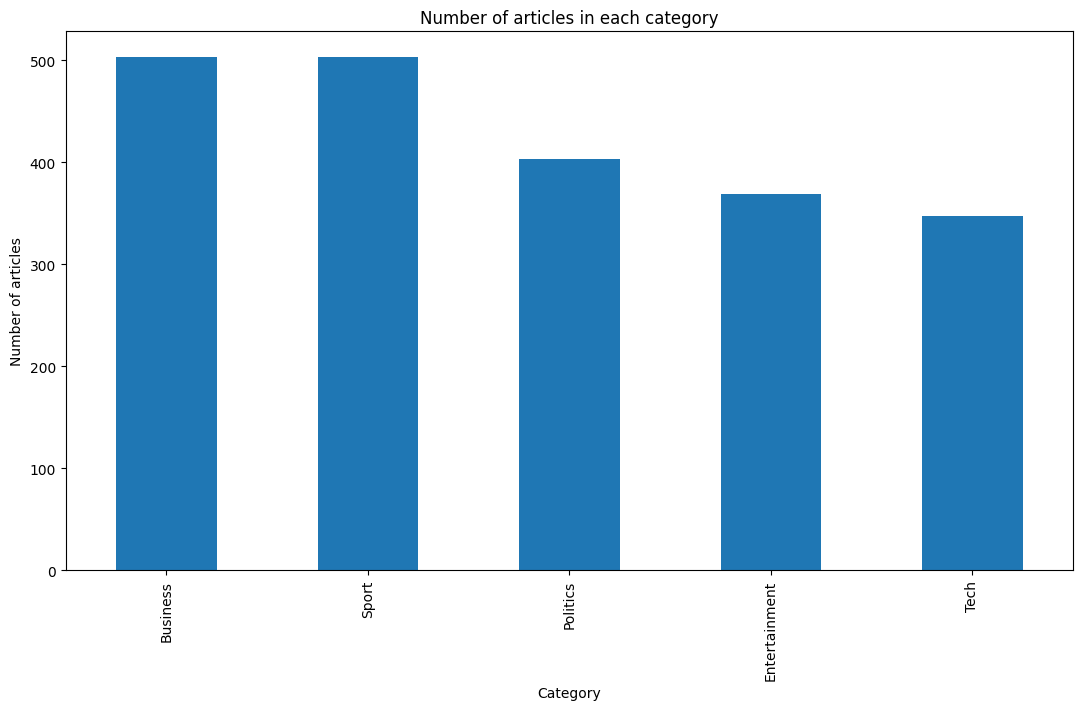

In [19]:
data['Category'].value_counts().plot(kind='bar', figsize = (13,7), title = 'Number of articles in each category', xlabel = 'Category', ylabel = 'Number of articles')
plt.show()

##### 1. Why did you pick the specific chart?

*   This bar plot was chosen to visually understand how the number of articles are distributed across the 5 given categories.

##### 2. What is/are the insight(s) found from the chart?

*   From the graph, it can be understood that Business and Sport categories have the highest number of articles after removing duplicate data, while Tech category had the lowest number of articles

#### Chart - 2 - Density plot for analysing the distribution of article length for each category

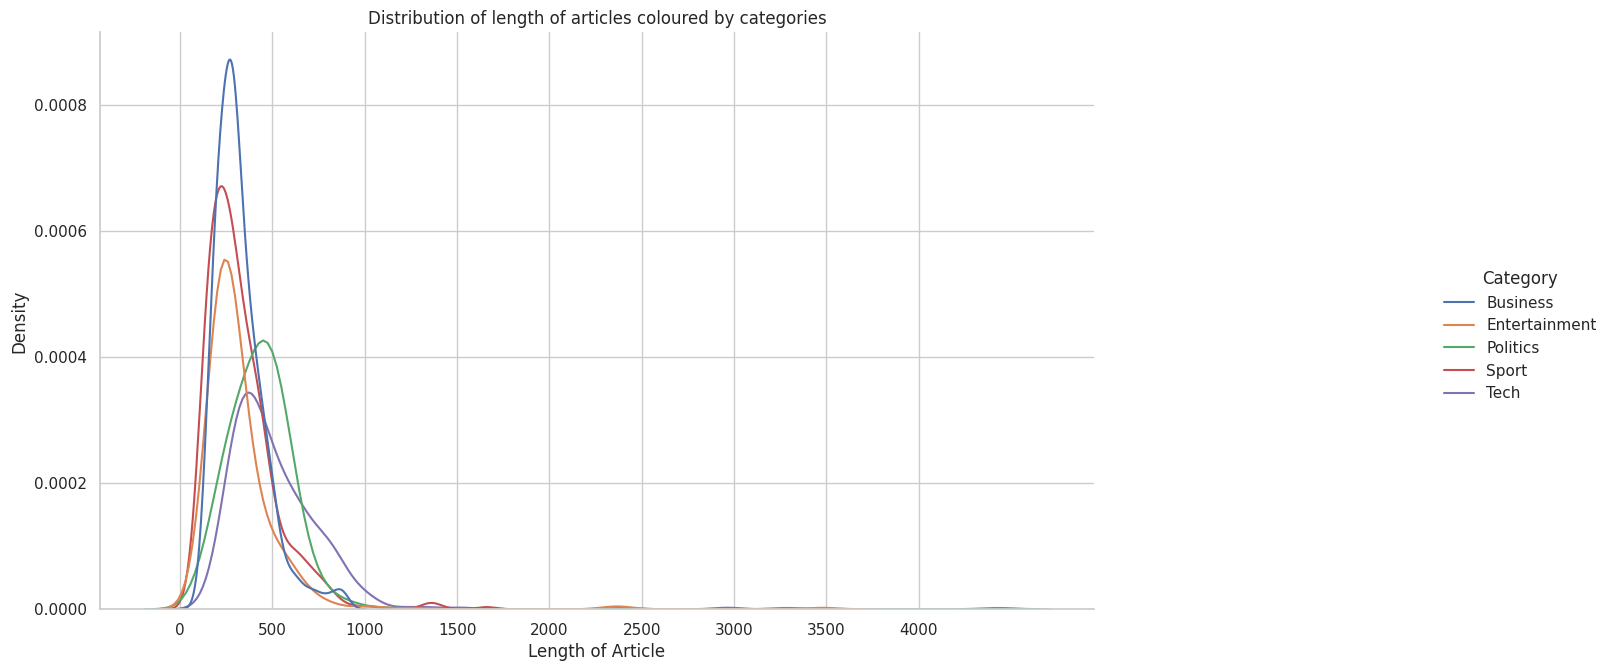

In [20]:
sns.set(style = 'whitegrid')
figu = sns.displot(x = data['Description'].str.split(' ').apply(len), hue = data['Category'], kind = 'kde')
figu.figure.set_size_inches(18,7)
figu.set(title = f'Distribution of length of articles coloured by categories', xlabel = 'Length of Article', xticks = range(0,4500,500))
plt.show()

##### 1. Why did you pick the specific chart?

*   This chart shows the distribution of article length for each category
*   A Density plot highlights how the article word count follows a specific distribution. Articles for all the categories are plot together to observe the differences in individual distributions

##### 2. What is/are the insight(s) found from the chart?

*   It can be observed that most articles are with word count of ~250
*   Articles from the politics category are usually longer in word count

##### 3. Will the gained insights help creating a positive business impact?

*   It can be observed that each category seems to follow a specific pattern for the number of words in each article. **This information could be used as a feature for predicting the Topic as part of a Supervised (Classification) Machine Learning problem**
*   For this particular problem, the dataset with only textual information is proceeded for pre-processing and analysis  

## **5. Feature Engineering & Data Pre-processing**

### 1. Textual Data Preprocessing

In [21]:
data.loc[1, 'Description']

" Parmalat, the Italian food group at the centre of one of Europe's most painful corporate scandals, has reported a doubling in profit. Its pre-tax earnings in the fourth quarter were 77m euros (£53m; $100m), up from 38m in the same period of 2003. Less welcome was the news that the firm had been fined 11m euros for having violated takeover rules five years ago. The firm sought bankruptcy protection in December 2003 after disclosing a 4bn-euro hole in its accounts. Overall, the company's debt is close to 12bn euros, and is falling only slowly. Its brands, well-known in Italy and overseas, have continued to perform strongly, however, and have barely lost revenue since the scandal broke. But a crucial factor for the company's future is the legal unwinding of its intensely complex financial position. On Tuesday, the company's administrator, turnaround expert Enrico Bondi, sued Morgan Stanley, its former banker, to return 136m euros relating to a 2003 bond deal. That brought to 49 the numb

*   It can be observed that the dataset contains several **punctuations** and **stopwords**. They shall be addressed in the following sections
*   Also, only the **data['Descriptions']** feature is made to undergo data pre-processing, since the Title is a subset of the article description

#### 1.1 Expanding Contractions

In [22]:
# Install and import contractions library
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.1 MB/s eta 0:00:00


In [23]:
import contractions

In [24]:
# Function for expanding contracted words
def expand_contractions(text):
  '''Expands contractions in textual data'''
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))
  return ' '.join(expanded_words)

In [25]:
data['Description'] = data['Description'].apply(expand_contractions)

#### 1.2 Lower Casing

In [26]:
def make_lower(text):
  return text.lower()

In [27]:
data['Description'] = data['Description'].apply(make_lower)

#### 1.3 Removing Punctuations

In [28]:
# Removes all Punctuations
def remove_punc(text):
  return re.sub(r'\W',' ',text)

In [29]:
data['Description'] = data['Description'].apply(remove_punc)

In [30]:
data.loc[1, 'Description']

'parmalat  the italian food group at the centre of one of europe s most painful corporate scandals  has reported a doubling in profit  its pre tax earnings in the fourth quarter were 77m euros   53m   100m   up from 38m in the same period of 2003  less welcome was the news that the firm had been fined 11m euros for having violated takeover rules five years ago  the firm sought bankruptcy protection in december 2003 after disclosing a 4bn euro hole in its accounts  overall  the company s debt is close to 12bn euros  and is falling only slowly  its brands  well known in italy and overseas  have continued to perform strongly  however  and have barely lost revenue since the scandal broke  but a crucial factor for the company s future is the legal unwinding of its intensely complex financial position  on tuesday  the company s administrator  turnaround expert enrico bondi  sued morgan stanley  its former banker  to return 136m euros relating to a 2003 bond deal  that brought to 49 the numbe

*   **Punctuations** have been removed from the dataset.

#### 1.4 Removing URLs, Digits and White Spaces

In [31]:
data['Description'].str.contains('http').sum()

0

*   No **URLs** are present in the Dataset.

In [32]:
# Functions for removing digits and whitespaces using re library
def remove_digits(text):
  return re.sub(r'\d',' ',text)

def remove_whitespace(text):
  return re.sub(r'\s+',' ',text)

In [33]:
data['Description'] = data['Description'].apply(remove_digits)
data['Description'] = data['Description'].apply(remove_whitespace)

In [34]:
data.loc[1, 'Description']

'parmalat the italian food group at the centre of one of europe s most painful corporate scandals has reported a doubling in profit its pre tax earnings in the fourth quarter were m euros m m up from m in the same period of less welcome was the news that the firm had been fined m euros for having violated takeover rules five years ago the firm sought bankruptcy protection in december after disclosing a bn euro hole in its accounts overall the company s debt is close to bn euros and is falling only slowly its brands well known in italy and overseas have continued to perform strongly however and have barely lost revenue since the scandal broke but a crucial factor for the company s future is the legal unwinding of its intensely complex financial position on tuesday the company s administrator turnaround expert enrico bondi sued morgan stanley its former banker to return m euros relating to a bond deal that brought to the number of banks that mr bondi has sued a mass of legal action that 

*   **Digits** and **whitespaces** removed from the dataset

#### 1.5 Removing Stopwords

In [35]:
# Remove Stopwords
def remove_stopwords(text, stop_words):
  '''Removes stopwords (given as input)  from text'''
  text = [word for word in text.split() if word.lower() not in stop_words]
  return ' '.join(text)

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
stop_words = stopwords.words('english')
data['Description'] = data['Description'].apply(remove_stopwords, stop_words = stop_words)

In [38]:
data.loc[1, 'Description']

'parmalat italian food group centre one europe painful corporate scandals reported doubling profit pre tax earnings fourth quarter euros period less welcome news firm fined euros violated takeover rules five years ago firm sought bankruptcy protection december disclosing bn euro hole accounts overall company debt close bn euros falling slowly brands well known italy overseas continued perform strongly however barely lost revenue since scandal broke crucial factor company future legal unwinding intensely complex financial position tuesday company administrator turnaround expert enrico bondi sued morgan stanley former banker return euros relating bond deal brought number banks mr bondi sued mass legal action could bring much bn euros company also sued former auditors financial advisors damages criminal cases company former management proceeding separately'

*   **Stopwords** have been removed from the dataset. Now, let's see the top 10 words in the dataset

In [39]:
def top_n_words_features(count_vectorizer, text, n_words):
    '''
    Returns a tuple. First element being a dataframe containing the top n words
    in a sample and their counts, given a CountVectorizer object and text sample
    Second element is the total number of unique words/features tokenised
    '''
    vectorized = count_vectorizer.fit_transform(text)
    tokens_df = pd.DataFrame(vectorized.todense(), columns = count_vectorizer.get_feature_names_out())
    top_df = pd.DataFrame(tokens_df.sum().sort_values(ascending=False).head(n_words)).rename(columns = {0:'Occurences'})
    return top_df, len(count_vectorizer.get_feature_names_out())

In [40]:
vectorizer = CountVectorizer()
top_words, n_features_raw = top_n_words_features(vectorizer, data['Description'], 10)

<Axes: >

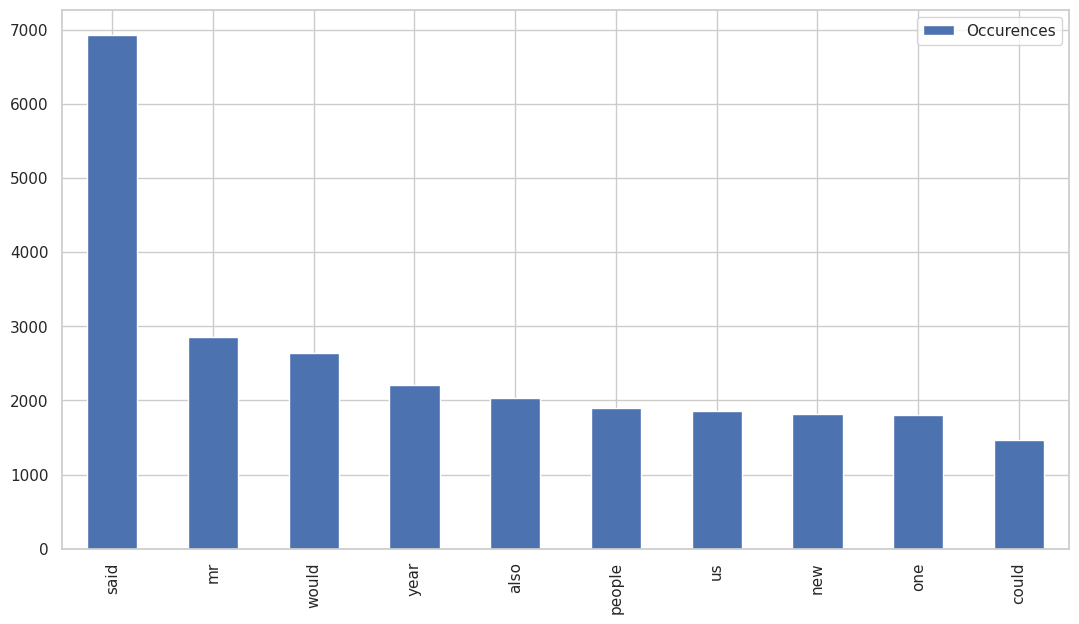

In [41]:
top_words.plot(kind='bar', figsize = (13,7))

In [42]:
n_features_raw

27573

*   It can be observed that there are 27573 unique words in the dataset. This is still a high number, and dimensionality reduction is required.

#### 1.6 Text Lemmatization

In [43]:
# Required downloads for Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [44]:
# Function for lemmatizing the verbs
def lemmatize_(text, lemmatizer):
  text = [lemmatizer.lemmatize(word, pos='v') for word in text.split()]
  return ' '.join(text)

In [45]:
lemmatiser =  WordNetLemmatizer()
data['Description'] = data['Description'].apply(lemmatize_, lemmatizer = lemmatiser)

In [46]:
top_words, n_features = top_n_words_features(vectorizer, data['Description'], 10)

<Axes: >

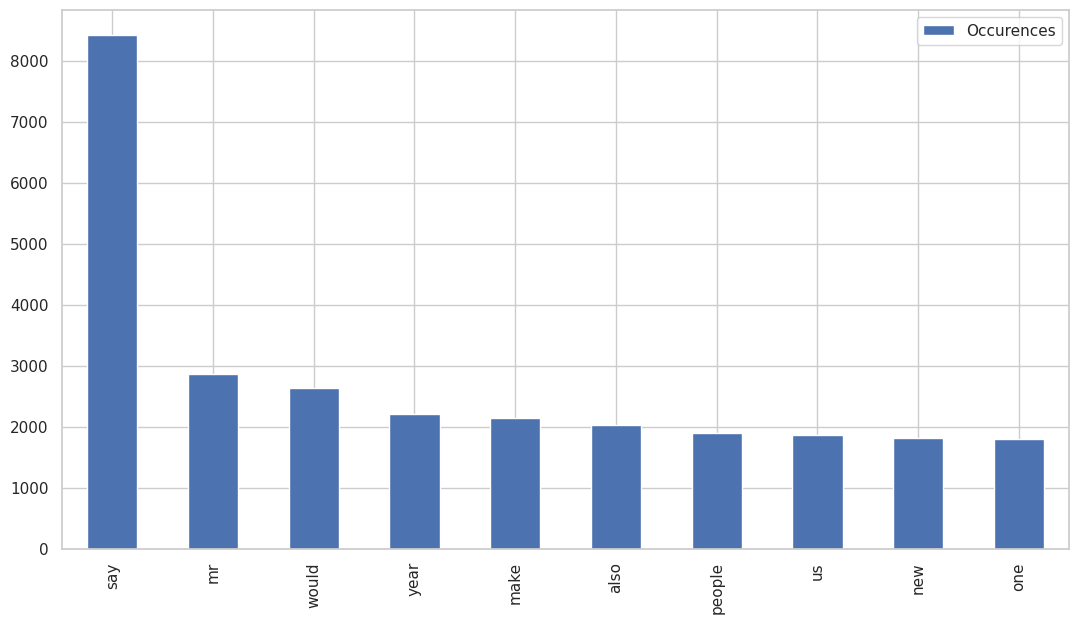

In [47]:
top_words.plot(kind='bar', figsize = (13,7))

In [48]:
n_features

22545

*   The number of unique features has been reduced to 22545
*   Here, **Text lemmetization** is chosen over stemming because the former is preferred for contextual analysis, i.e., the context in which word is used is important. Since this is crucial for Topic Modelling, Lemmatization is preferred

#### 1.7 Removing further Stopwords

*   It can be observed that, a few very frequent words like "say", "mr", "would", "also" etc do not contribute to decision of a Topic/category. Hence these words, on account of being too frequent, could be eliminated

In [49]:
stop_words.extend(['say', 'mr', 'would', 'also'])
data['Description'] = data['Description'].apply(remove_stopwords, stop_words = stop_words)

<Axes: >

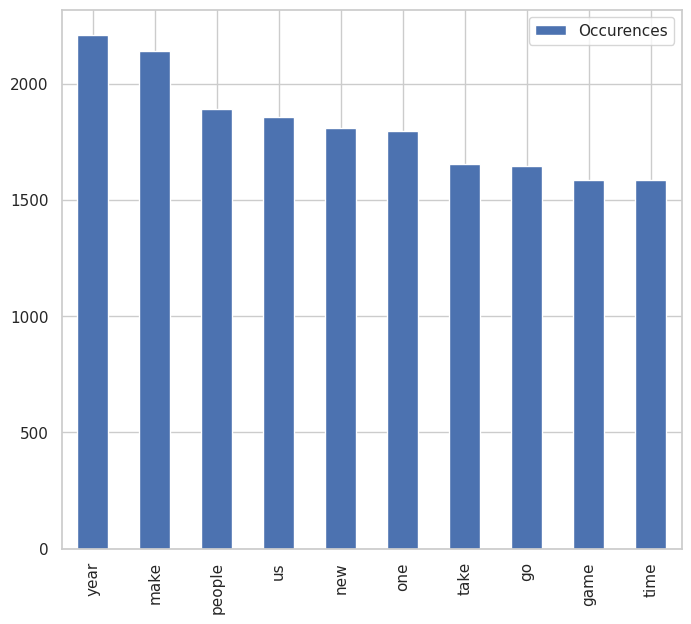

In [51]:
top_n_words_features(vectorizer, data['Description'], 10)[0].plot(kind='bar', figsize = (8,7))

#### 1.8 Text Vectorization

In [52]:
# Vectorizing Text
tokeniser = CountVectorizer(max_df = 0.95, min_df = 0.02)
tokenised_data = tokeniser.fit_transform(data['Description'])

In [53]:
top_words, n_features = top_n_words_features(tokeniser, data['Description'], 10)

<Axes: >

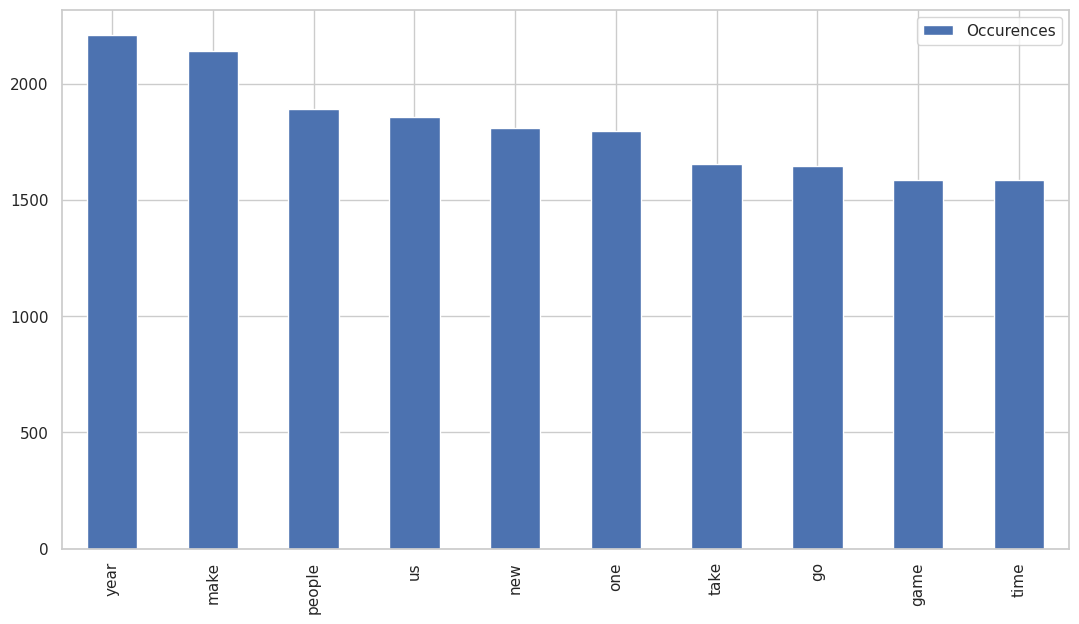

In [54]:
top_words.plot(kind = 'bar', figsize = (13,7))

In [55]:
print(f'Number of features after vectorization = {n_features}')
print(f'\nAfter Text Pre-processing, {round((n_features_raw - n_features)*100/n_features_raw, 2)}% of contextually insignificant features have been removed')

Number of features after vectorization = 1436

After Text Pre-processing, 94.79% of contextually insignificant features have been removed


*   It can be observed that the number of features has reduced by a great number due to the addition of the keyword arguments max_df and min_df. Now, the number of documents is greater in number than the number of features, we may proceed with model building

##### Which text vectorization technique have you used and why?

*   **Count Vectorization** is chosen for Vectorizing the text. This is because LDA as a word generating algorithm inherently deals with term counts to generate words from a multinomial distribution.
*   **NOTE**: **The above statement is considered as a Null Hypotheses statement.** To validate it, the Tfidf-Vectorizer was utilised for Text vectorization. Refer the next section for more details

## **6. ML Model Implementation**

### ML Model - 1 - **Latent Dirichlet Allocation**

#### 1. Model implementation

*   The business requirement here is 5 topics. Still, the Hyperparameter  **number of topics** is tuned to compute its optimum number by using GridSearchCV for number of topics greater than or equal to five
*   If the optimum number  topics is greater than five, appropriate topics can be combined to categorise the documents to five topics  

In [56]:
# Fitting an LDA model with Hyperparameter tuning on the tokenised_data
%%time
lda = LatentDirichletAllocation(random_state = 42)
grid_params = {'n_components' : list(range(5,10))}                 # Number of topics in range of [5,10)
lda_model = GridSearchCV(lda, param_grid = grid_params)
lda_model.fit(tokenised_data)

CPU times: user 5min 11s, sys: 2.15 s, total: 5min 14s
Wall time: 5min 26s


GridSearchCV(estimator=LatentDirichletAllocation(random_state=42),
             param_grid={'n_components': [5, 6, 7, 8, 9]})

In [57]:
best_lda_model = lda_model.best_estimator_
log_likelihood_m1 = lda_model.best_score_
perplexity_m1 = best_lda_model.perplexity(tokenised_data)
print("Parameters of Best LDA Model" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model", log_likelihood_m1)
print("Perplixity Score on the LDA model", perplexity_m1)

Parameters of Best LDA Model {'n_components': 5}
Best log likelihood Score for the LDA model -440013.84350437595
Perplixity Score on the LDA model 742.406788750559


*   It can be observed that the **optimum number of topics is five**, which is the business requirement as well. So we proceed with this best LDA model

##### Which hyperparameter optimization technique have you used and why?

*   Algorithms like **GridSearch** and **RandomSearch** were introduced to automate the process of running the model on various desired combinations of components that the user wishes to optimise, instead of manually running through every combination which is not only time consuming, but also requires regular involvement of the user
*   **RandomSearch** is a method which tries out random combinations of the hyperparameter values to be tuned, unlike GridSearchCV which runs through all the possible combinations.
*   **In this case, GridSearchCV is sufficient** as the computational time is not very high (~5-10 minutes at the maximum), and there is only one hyperparameter which is being tuned.

#### 2. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

##### 2.1 Visualisation

In [ ]:
!pip install pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
try:
  lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, tokenised_data, tokeniser, mds='tsne')
  lda_panel
except AttributeError:
  pass

*   The five topics can be observed in the above visualisation tool for LDA. Each five topics have the relevant words pertaining to its category (Sport, Business etc). We shall analyse the them further and compare with the input Categories provided.
*    **NOTE: Recently, the method 'get_feature_names' was updated to 'get_feature_names_out' in sklearn. pyLDAvis has not yet been updated and hence is incompatible as of now. Hence, exception handling has been used. Refer image below**

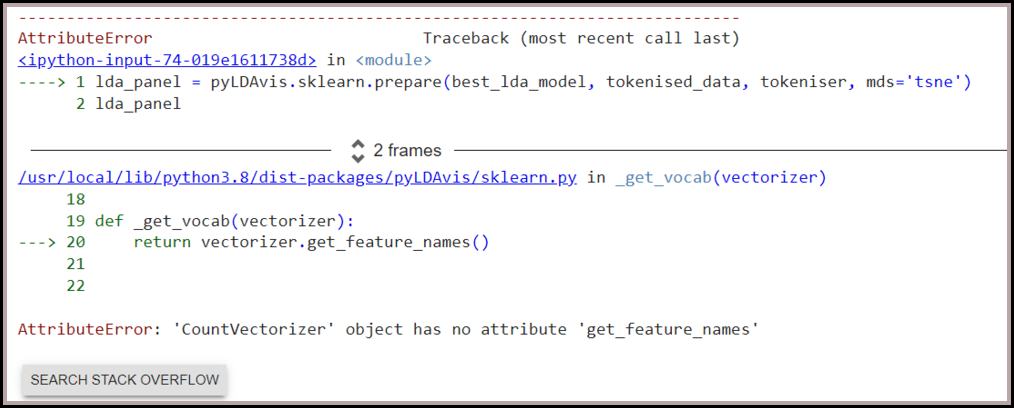

##### 2.2 Assigning the Topic labels to each document

In [58]:
lda_model.transform(tokenised_data[0])

array([[0.24948783, 0.50252353, 0.24503133, 0.00148232, 0.00147498]])

*   For a particular document, the probability of it belonging to each of the five topics is obtained after using the LDA model
*   The **(index+1)** is used as the model label temporarily. For eg, the topic assigned for the above document will be 2, since it has the maximum probability
*   **NOTE**: This is NOT necessarily the same as the numbers assigned in the pyLDAvis tool

In [59]:
def assign_topics(data, tokenised, model):
  ''' Assigns topics for each document based on highest probability of a topic for each document.
      Returns the input dataframe with the additional column of Topics assigned through the model.
      Inputs include the pre-processed data, tokenised data and the model itself'''

  # Array of probabilites for each topic for each document. Shape - (n_documents, n_topics)
  topic_dist = model.transform(tokenised)

  topics = []
  # Assigns (index+1) of the topic with maximum probability as the topic name for the particular document
  for doc in topic_dist:
    topics.append(np.argmax(np.abs(doc))+1)

  # Convert to a Dataframe and merge with the original pre-processed dataframe with documents as an additional column
  topics_df = pd.DataFrame(topics).rename(columns = {0:'Topic_LDA'})
  return pd.merge(data, topics_df, left_index = True, right_index = True)

In [60]:
result_df = assign_topics(data, tokenised_data, best_lda_model)

In [61]:
result_df.head(2)

Title  \
0  Rank 'set to sell off film unit'   
1   Parmalat boasts doubled profits   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Description  \
0  leisure group rank could unveil plan demerge film service unit sell media business report claim rank formerly famous carry series expose shake announcement result friday sunday telegraph report advisors goldman sachs understand value demerged deluxe film unit report add speculation possible shake mount since rank announce study possible demerger september since mike smith appointment chief executive group focus fewer businesses embark major cost cut programme see dispose number businesses include odeon cinema chain pinewood studios move leave group three core divisions game hard rock deluxe film provide technical service hollywood studios rank aim concentrate game bar hotels business include extend hard rock brand casinos trials success deluxe media make distribute dvds videos however business see less successful last year make profit turnover experts suggest success move dvds vhs video could make attractive target private equity buyer spokesman firm refuse comment report result demerger study likely set unveil result friday analysts predict firm likely report slight drop annual pre tax profit last year form firm lead uk film producer cinema owner many years diversify range leisure activities mainly uk include hotels roadside service areas holiday centre grosvenor casinos mecca bingo chain hard rock cafes countries   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         parmalat italian food group centre one europe painful corporate scandals report double profit pre tax earn fourth quarter euros period less welcome news firm fin euros violate takeover rule five years ago firm seek bankruptcy protection december disclose bn euro hole account overall company debt close bn euros fall slowly brand well know italy overseas continue perform strongly however barely lose revenue since scandal break crucial factor company future legal unwind intensely complex financial position tuesday company administrator turnaround expert enrico bondi sue morgan stanley former banker return euros relate bond deal bring number bank bondi sue mass legal action could bring much bn euros

##### 2.3 Comparison of Topics obtained through LDA with input Categories

In [62]:
result_df.groupby(['Category', 'Topic_LDA'])['Title'].count()

Category       Topic_LDA
Business       2            428
               3             13
               4             61
               5              1
Entertainment  1            340
               2              3
               3              9
               4             15
               5              2
Politics       1              1
               3              4
               4            397
               5              1
Sport          1              2
               2              3
               4              3
               5            495
Tech           1             10
               2              4
               3            314
               4              8
               5             11
Name: Title, dtype: int64

*   It can be observed above that for each of the Categories, the implemented LDA model predicted with high precision
*   For example, for articles originally tagged '**Business**', the LDA model has predicted **430 of 503 correctly**, labeled as **2**
*   This result is used to map the input Topics and LDA topics one-to-one. In the above case, 2 as Business and so on

In [63]:
def convert_labels(result):
  '''Converts the integer labels to Category names'''

  to_map = result.groupby(['Category', 'Topic_LDA'], as_index=False)['Title'].count()

  # Converts the groupby dataframe to a Dataframe with first column as input category and second as the label through LDA to be mapped
  to_map = to_map.groupby('Category', as_index=False).apply(lambda x: x['Topic_LDA'][x['Title'].idxmax()]).rename(columns = str).rename(columns = {'None':'LDA'})

  # Mapping and updating the TOpic_LDA column
  to_map_dict = dict(zip(to_map['LDA'], to_map['Category']))
  result['Topic_LDA'] = result['Topic_LDA'].map(to_map_dict)
  for category in to_map_dict:
    print(f'{category} is mapped to {to_map_dict[category]}')
  return result

In [64]:
result_df = convert_labels(result_df)

2 is mapped to Business
1 is mapped to Entertainment
4 is mapped to Politics
5 is mapped to Sport
3 is mapped to Tech


In [65]:
result_df.head(2)

Title  \
0  Rank 'set to sell off film unit'   
1   Parmalat boasts doubled profits   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Description  \
0  leisure group rank could unveil plan demerge film service unit sell media business report claim rank formerly famous carry series expose shake announcement result friday sunday telegraph report advisors goldman sachs understand value demerged deluxe film unit report add speculation possible shake mount since rank announce study possible demerger september since mike smith appointment chief executive group focus fewer businesses embark major cost cut programme see dispose number businesses include odeon cinema chain pinewood studios move leave group three core divisions game hard rock deluxe film provide technical service hollywood studios rank aim concentrate game bar hotels business include extend hard rock brand casinos trials success deluxe media make distribute dvds videos however business see less successful last year make profit turnover experts suggest success move dvds vhs video could make attractive target private equity buyer spokesman firm refuse comment report result demerger study likely set unveil result friday analysts predict firm likely report slight drop annual pre tax profit last year form firm lead uk film producer cinema owner many years diversify range leisure activities mainly uk include hotels roadside service areas holiday centre grosvenor casinos mecca bingo chain hard rock cafes countries   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         parmalat italian food group centre one europe painful corporate scandals report double profit pre tax earn fourth quarter euros period less welcome news firm fin euros violate takeover rule five years ago firm seek bankruptcy protection december disclose bn euro hole account overall company debt close bn euros fall slowly brand well know italy overseas continue perform strongly however barely lose revenue since scandal break crucial factor company future legal unwind intensely complex financial position tuesday company administrator turnaround expert enrico bondi sue morgan stanley former banker return euros relate bond deal bring number bank bondi sue mass legal action could bring much bn euros

##### 2.4 Computing the Model Accuracy and individual Topic Precisions, Recalls, and F1 Scores

In [66]:
# Plotting the count of Articles categorised by each category and comparing with input Categories
def aggregate_plot(result_df):
  '''Plots the number of articles categorised in each category by the LDA
  and compared with the original categorisation provided as input'''
  aggregated_input = pd.DataFrame(result_df['Category'].value_counts())
  aggregated_LDA = pd.DataFrame(result_df['Topic_LDA'].value_counts())
  aggregated = pd.merge(aggregated_input, aggregated_LDA, left_index=True, right_index=True)
  aggregated.plot(kind='bar', figsize=(13,7))
  plt.show()

# Computing the model accuracy
def model_accuracy(result):
  '''Computes the model accuracy, defined as the number of articles
  correctly categorised to the total number of articles'''

  df1 = result.groupby(['Category', 'Topic_LDA'], as_index=False)['Title'].count().rename(columns = {'Title':'Count'})

  # Articles correctly categorised in the topic
  correct_preds = df1[df1['Category'] == df1['Topic_LDA']]['Count'].reset_index()['Count'].sum()

  total_accuracy = correct_preds/result.shape[0]
  return total_accuracy * 100

# Computing the precision, recall and F1 scores for each topic modeled by the LDA model
def topic_precision(dfp):
  '''Defined as the number of articles correctly categorised to the total articles in the topic through LDA'''

  # Total articles present in each topic through LDA (TP + FP)
  predicted_articles_total = dfp.groupby('Topic_LDA')['Count'].sum().reset_index()

  # Articles correctly categorised in each topic (TP)
  predicted_articles = dfp[dfp['Category'] == dfp['Topic_LDA']]['Count'].reset_index()['Count']

  # Calculating the precision
  predicted_articles_total['Count'] = (predicted_articles/predicted_articles_total['Count'])*100
  return predicted_articles_total.rename(columns = {'Count':'Precision', 'Topic_LDA':'Topic'})

def topic_recall(dfr):
  '''Defined as the number of articles correctly categorised to the total articles originally in the topic'''

  # Total articles present in each topic through LDA (TP + FN)
  predicted_articles_total = dfr.groupby('Category')['Count'].sum().reset_index()

  # Articles correctly categorised in each topic (TP)
  predicted_articles = dfr[dfr['Category'] == dfr['Topic_LDA']]['Count'].reset_index()['Count']

  # Calculating the Recall
  predicted_articles_total['Count'] = (predicted_articles/predicted_articles_total['Count'])*100
  return predicted_articles_total.rename(columns = {'Count':'Recall', 'Category':'Topic'})

def precision_recall_f1(result):
  ''' Gives the precision, recall, and F1 score for each category'''

  df1 = result.groupby(['Category', 'Topic_LDA'], as_index=False)['Title'].count().rename(columns = {'Title':'Count'})

  # Calculating precision and adding a column
  precisions = topic_precision(df1)

  # Calculating recall and adding a column
  recalls = topic_recall(df1)

  # Merging and Calculating F1 Score
  prf1 = pd.merge(recalls, precisions, on = 'Topic')
  prf1['F1_Score'] = (2*prf1['Precision']*prf1['Recall'])/(prf1['Precision'] + prf1['Recall'])
  return prf1

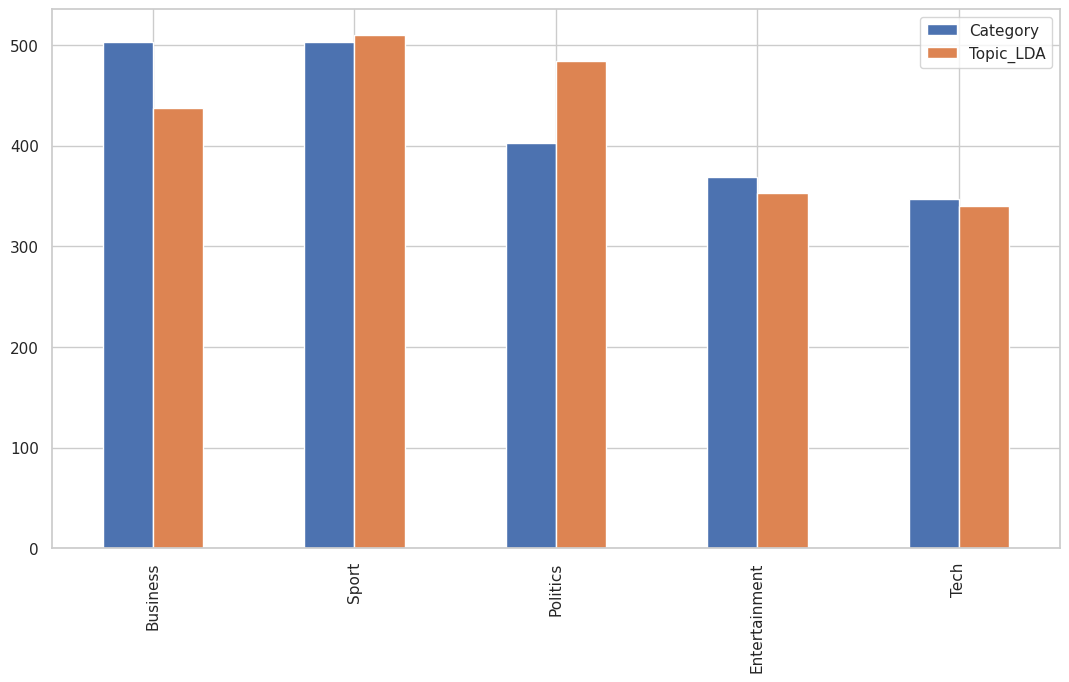

In [67]:
aggregate_plot(result_df)

In [68]:
print(f'The LDA model has an accuracy of {round(model_accuracy(result_df),2)}%')

The LDA model has an accuracy of 92.89%


In [69]:
prf1_m1 = precision_recall_f1(result_df)
prf1_m1

Topic     Recall  Precision   F1_Score
0       Business  85.089463  97.716895  90.967056
1  Entertainment  92.140921  96.317280  94.182825
2       Politics  98.511166  82.024793  89.515220
3          Sport  98.409543  97.058824  97.729516
4           Tech  90.489914  92.352941  91.411936

*   It can be observed that the LDA model has a good accuracy and excellent F1 scores in Topic modeling for most of the Categories.

##### 2.5 Topic-wise analysis - Term distributions for each Topic

In [70]:
def top_n_terms(vectorizer, model, n_top_words):
  '''Takes the vectorizer, model and the required number of most frequent words
  as input and returns a list of length (number of topics), each element being a
  dictionary of the word and its frequency of occurence in the particular topic'''

  # List of all words vectorized
  words = vectorizer.get_feature_names_out()

  # List of 5 dictionaries
  top_words_topic = []
  for topic, weights in enumerate(model.components_):
    word_weights = dict()

    # Indices of top n words
    indices = np.argsort(weights)[::-1][:n_top_words]

    # Top n words and their weights
    top_words = words[indices]
    top_weights = weights[indices]

    for i in range(len(words[indices])):
      word_weights[top_words[i]] = top_weights[i]
    top_words_topic.append(word_weights)
  return top_words_topic

def plot_wordcloud(topic_term_freq):
  '''Plots a word cloud, sizing proportional to frequency of the word in the topic'''

  colours = ['black', 'darkslateblue', 'darkolivegreen', 'khaki']
  wordcloud = WordCloud(width = 1300, height = 800,
                  background_color = random.choice(colours),
                  min_font_size = 10).generate(' '.join(list(topic_term_freq.keys())))
  wordcloud = wordcloud.generate_from_frequencies(frequencies = topic_term_freq)
  plt.figure(figsize = (13,8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  plt.show()

In [71]:
# Getting the top 100 words for each topic
top_words = top_n_terms(tokeniser, best_lda_model, 100)
print(top_words[0])

{'film': 1063.194270528972, 'best': 655.2624881630254, 'award': 595.5521031082254, 'music': 519.0744288074668, 'show': 499.1339931677348, 'year': 481.9091006602422, 'star': 440.85117046145496, 'one': 382.4962258771831, 'include': 375.11138535753486, 'us': 328.5699577833157, 'make': 316.9161543480203, 'new': 316.71198617466564, 'take': 301.88795737198814, 'top': 274.40139673520986, 'first': 272.45950002794604, 'go': 249.14786491867065, 'tv': 239.4344830985697, 'band': 238.8163279741836, 'uk': 238.14986127295288, 'record': 234.1126787851888, 'years': 232.24423780684904, 'last': 227.59049865707144, 'play': 225.90891892067955, 'release': 224.0257186236295, 'two': 219.07368613335652, 'british': 216.66355864134601, 'director': 214.78547563297218, 'number': 213.5449223246285, 'time': 202.75287094042542, 'actor': 194.19755771465162, 'bbc': 190.14623719851417, 'album': 175.19881996918826, 'song': 174.19553864955898, 'prize': 173.4237894798379, 'chart': 172.19557414830626, 'three': 169.799349663

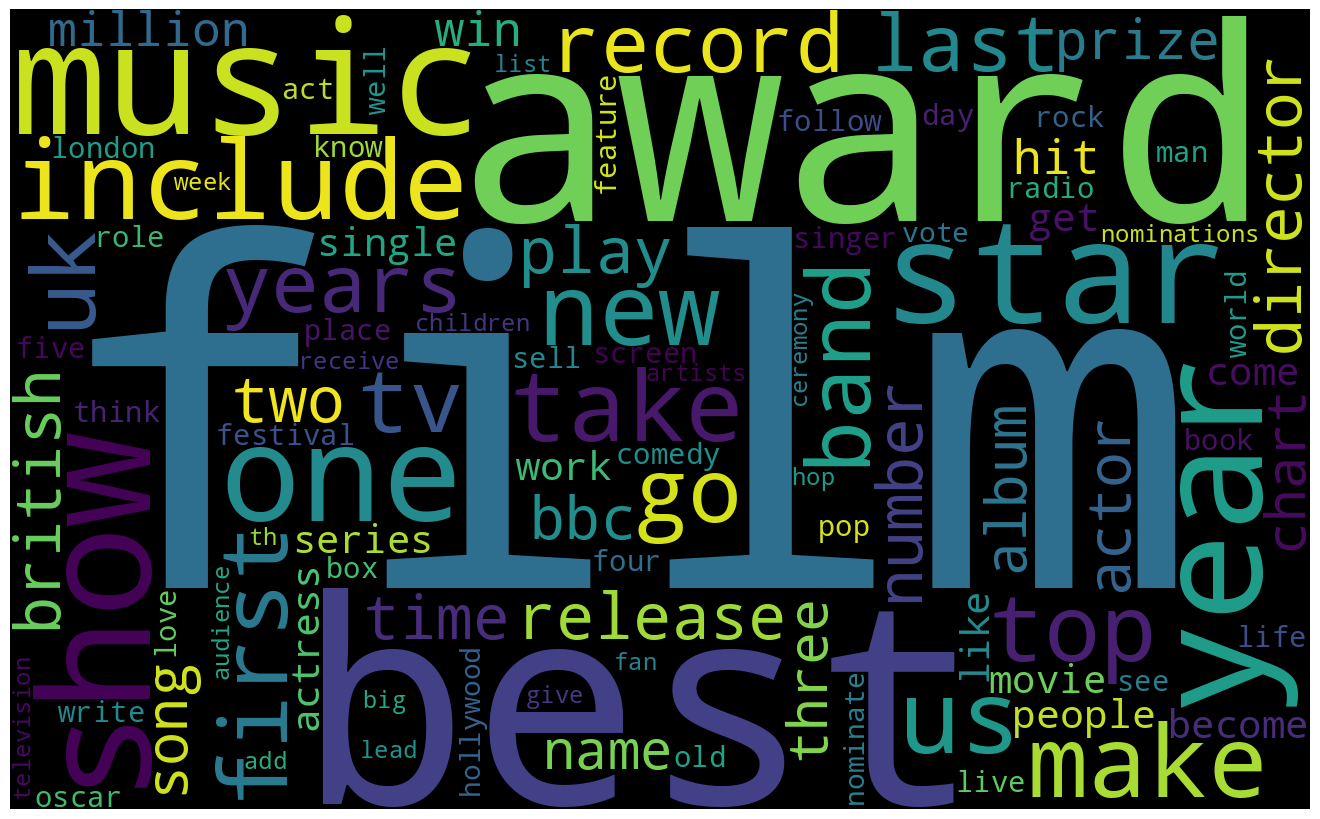

In [72]:
plot_wordcloud(top_words[0])

*   Looking at the word distributions, it can be concluded that this is the **Entertainment** Topic

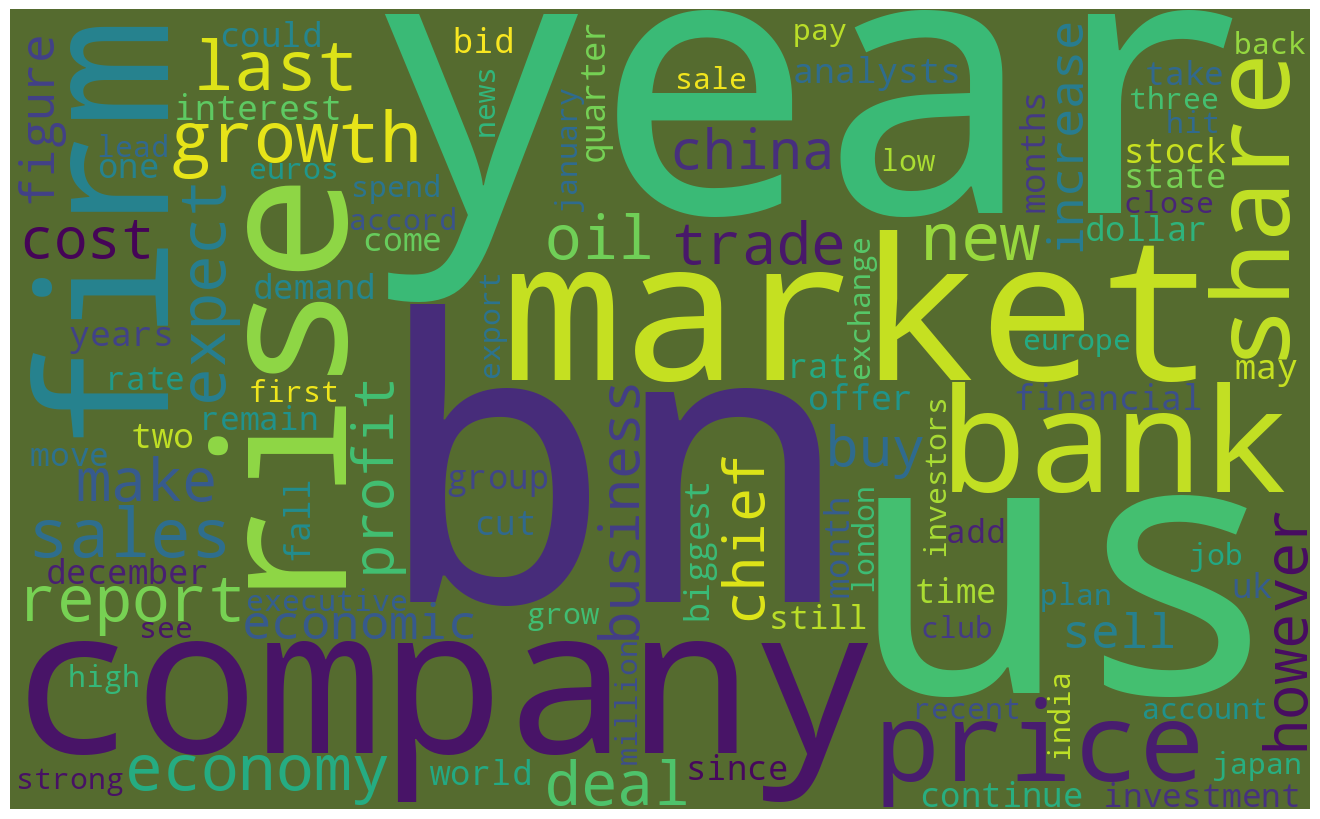

In [73]:
plot_wordcloud(top_words[1])

*   Looking at the word distributions, it can be concluded that this is the **Business** Topic

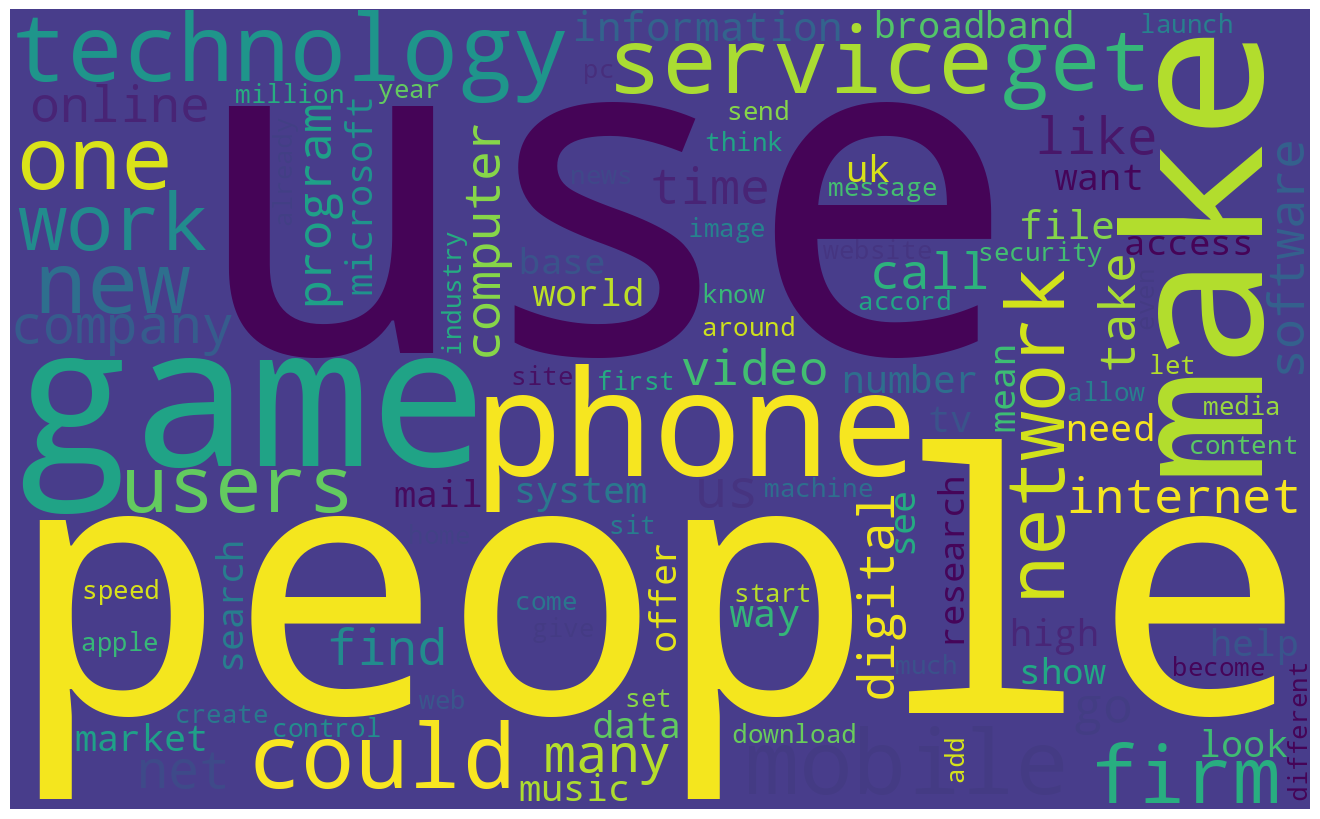

In [74]:
plot_wordcloud(top_words[2])

*   Looking at the word distributions, it can be concluded that this is the **Tech** Topic

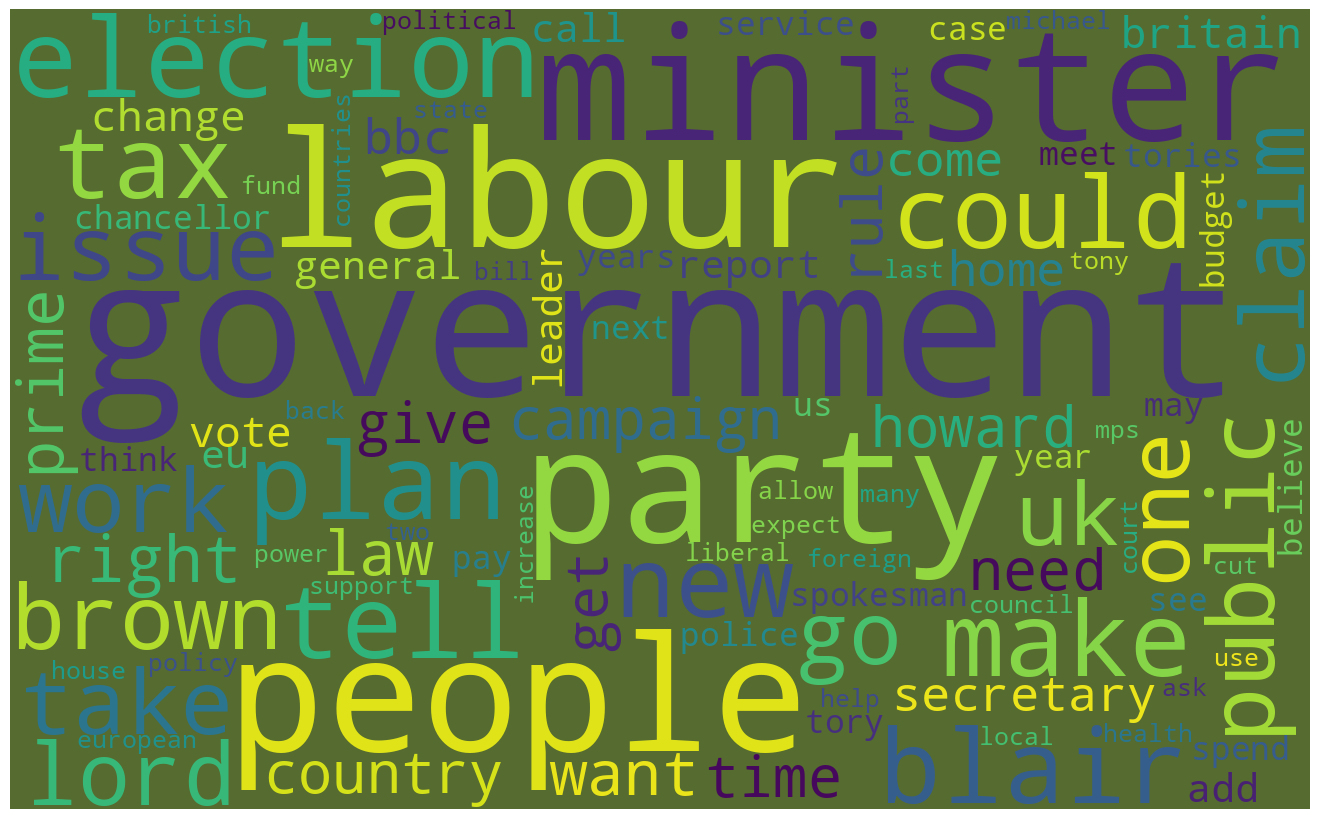

In [75]:
plot_wordcloud(top_words[3])

*   Looking at the word distributions, it can be concluded that this is the **Politics** Topic

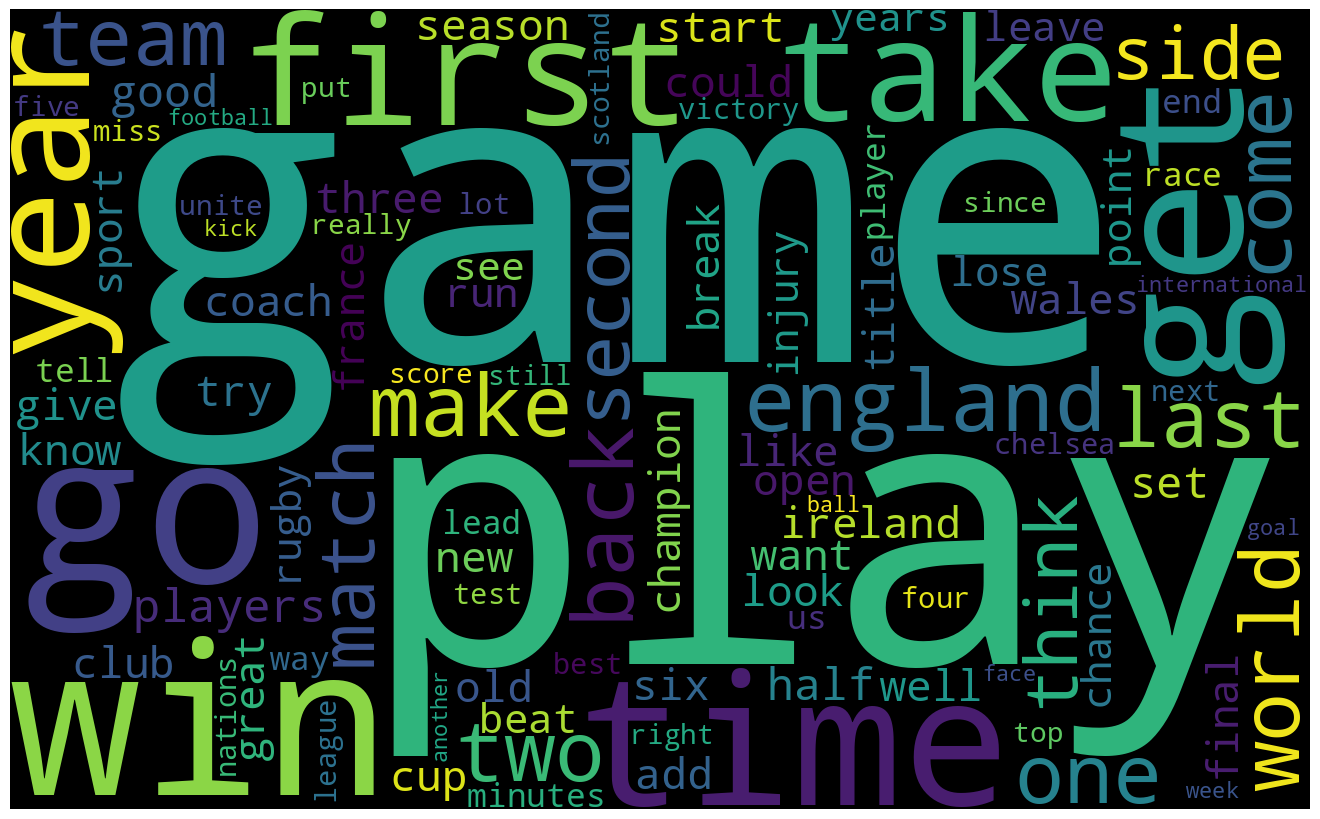

In [76]:
plot_wordcloud(top_words[4])

*   Looking at the word distributions, it can be concluded that this is the **Sport** Topic

### ML Model - 2 - **Latent Dirichlet Allocation with TFIDF Vectorizer**

#### 1. Model implementation

As the second model, the LDA Algorithm is used with TFIDF-Vectorizer as vectorization method on the dataset

In [77]:
%%time
# Vectorizing using the TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 0.02)
tfidf_vectorized = tfidf_vectorizer.fit_transform(data['Description'])

print(f'The number of features/tokens after TFIDF Vectorizer is {len(tfidf_vectorizer.get_feature_names_out())}\n')

# Fitting the LDA model on the TFIDF-vectorized data
lda = LatentDirichletAllocation(random_state = 15)
grid_params = {'n_components' : list(range(5,10))}
lda_model_2 = GridSearchCV(lda, param_grid = grid_params)
lda_model_2.fit(tfidf_vectorized)

The number of features/tokens after TFIDF Vectorizer is 1436

CPU times: user 2min 4s, sys: 523 ms, total: 2min 5s
Wall time: 2min 6s


GridSearchCV(estimator=LatentDirichletAllocation(random_state=15),
             param_grid={'n_components': [5, 6, 7, 8, 9]})

In [78]:
# Printing the characteristics of the best model by TFIDF vectorization
best_lda_model_tfidf = lda_model_2.best_estimator_
log_likelihood_m2 = lda_model_2.best_score_
perplexity_m2 = best_lda_model_tfidf.perplexity(tfidf_vectorized)
print("Parameters of Best LDA Model" , lda_model_2.best_params_)
print("Best log likelihood Score for the LDA model", log_likelihood_m2)
print("Perplexity of LDA model with TfidfVectorizer on data", perplexity_m2)

Parameters of Best LDA Model {'n_components': 5}
Best log likelihood Score for the LDA model -30188.01678182443
Perplexity of LDA model with TfidfVectorizer on data 2195.839426500326


#### 2. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

##### 2.1 Visualisation

In [ ]:
# Visualising the Topics
try:
  lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, tokenised_data, tokeniser, mds='tsne')
  lda_panel
except AttributeError:
  pass

##### 2.2 Assigning the Topic names to each document

*   Like in the previous model, each topic article is assigned to a topic label based on the probabilities of each topic for each document

In [79]:
# Assigning the topics for each document based on maximum probability
result_df_tfidf = assign_topics(data, tfidf_vectorized, best_lda_model_tfidf)
result_df_tfidf.head(2)

Title  \
0  Rank 'set to sell off film unit'   
1   Parmalat boasts doubled profits   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Description  \
0  leisure group rank could unveil plan demerge film service unit sell media business report claim rank formerly famous carry series expose shake announcement result friday sunday telegraph report advisors goldman sachs understand value demerged deluxe film unit report add speculation possible shake mount since rank announce study possible demerger september since mike smith appointment chief executive group focus fewer businesses embark major cost cut programme see dispose number businesses include odeon cinema chain pinewood studios move leave group three core divisions game hard rock deluxe film provide technical service hollywood studios rank aim concentrate game bar hotels business include extend hard rock brand casinos trials success deluxe media make distribute dvds videos however business see less successful last year make profit turnover experts suggest success move dvds vhs video could make attractive target private equity buyer spokesman firm refuse comment report result demerger study likely set unveil result friday analysts predict firm likely report slight drop annual pre tax profit last year form firm lead uk film producer cinema owner many years diversify range leisure activities mainly uk include hotels roadside service areas holiday centre grosvenor casinos mecca bingo chain hard rock cafes countries   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         parmalat italian food group centre one europe painful corporate scandals report double profit pre tax earn fourth quarter euros period less welcome news firm fin euros violate takeover rule five years ago firm seek bankruptcy protection december disclose bn euro hole account overall company debt close bn euros fall slowly brand well know italy overseas continue perform strongly however barely lose revenue since scandal break crucial factor company future legal unwind intensely complex financial position tuesday company administrator turnaround expert enrico bondi sue morgan stanley former banker return euros relate bond deal bring number bank bondi sue mass legal action could bring much bn euros

##### 2.3 Comparison of Topics obtained through LDA with input Categories

In [80]:
result_df_tfidf.groupby(['Category', 'Topic_LDA'], as_index=True)['Title'].count()

Category       Topic_LDA
Business       1            458
               3              6
               4             39
Entertainment  1              6
               2             64
               4            299
Politics       1              9
               3              1
               4            393
Sport          2             66
               4            437
Tech           1              5
               2              2
               3            282
               4             58
Name: Title, dtype: int64

In [81]:
# Converting the label names
result_df_tfidf = convert_labels(result_df_tfidf)

1 is mapped to Business
4 is mapped to Sport
3 is mapped to Tech


In [82]:
result_df_tfidf.head(2)

Title  \
0  Rank 'set to sell off film unit'   
1   Parmalat boasts doubled profits   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Description  \
0  leisure group rank could unveil plan demerge film service unit sell media business report claim rank formerly famous carry series expose shake announcement result friday sunday telegraph report advisors goldman sachs understand value demerged deluxe film unit report add speculation possible shake mount since rank announce study possible demerger september since mike smith appointment chief executive group focus fewer businesses embark major cost cut programme see dispose number businesses include odeon cinema chain pinewood studios move leave group three core divisions game hard rock deluxe film provide technical service hollywood studios rank aim concentrate game bar hotels business include extend hard rock brand casinos trials success deluxe media make distribute dvds videos however business see less successful last year make profit turnover experts suggest success move dvds vhs video could make attractive target private equity buyer spokesman firm refuse comment report result demerger study likely set unveil result friday analysts predict firm likely report slight drop annual pre tax profit last year form firm lead uk film producer cinema owner many years diversify range leisure activities mainly uk include hotels roadside service areas holiday centre grosvenor casinos mecca bingo chain hard rock cafes countries   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         parmalat italian food group centre one europe painful corporate scandals report double profit pre tax earn fourth quarter euros period less welcome news firm fin euros violate takeover rule five years ago firm seek bankruptcy protection december disclose bn euro hole account overall company debt close bn euros fall slowly brand well know italy overseas continue perform strongly however barely lose revenue since scandal break crucial factor company future legal unwind intensely complex financial position tuesday company administrator turnaround expert enrico bondi sue morgan stanley former banker return euros relate bond deal bring number bank bondi sue mass legal action could bring much bn euros

##### 2.4 Computing the Model Accuracy and individual Topic Precisions, Recalls, and F1 Scores

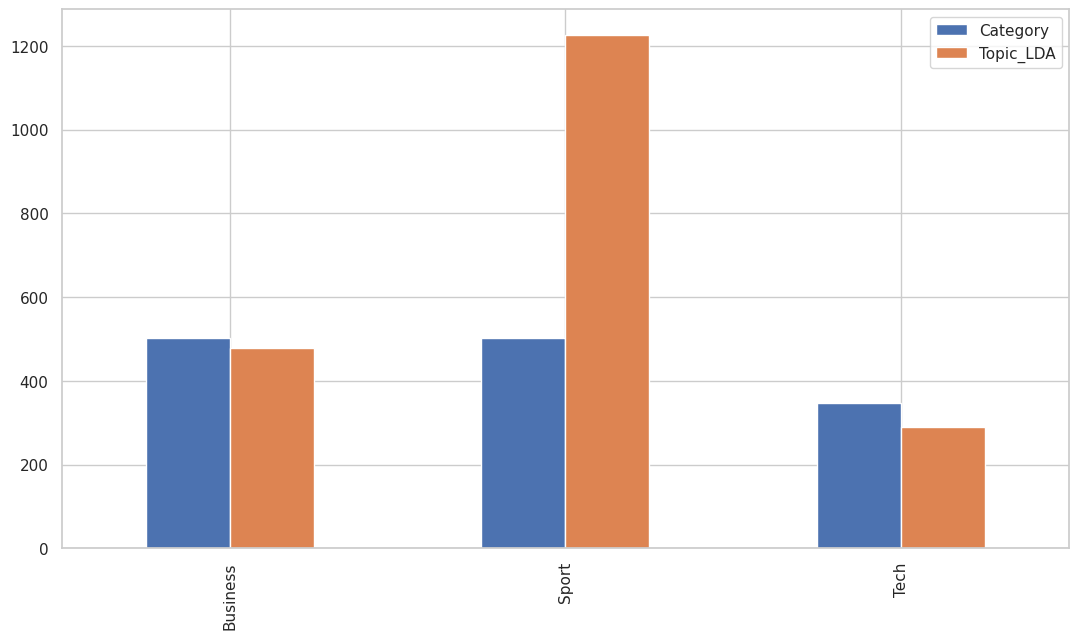

In [83]:
aggregate_plot(result_df_tfidf)

In [84]:
print(f'The LDA model has an accuracy of {round(model_accuracy(result_df_tfidf),2)}%')

The LDA model has an accuracy of 55.39%


In [85]:
prf1_m2 = precision_recall_f1(result_df_tfidf)
prf1_m2

Topic     Recall  Precision   F1_Score
0  Business  91.053678  95.815900  93.374108
1     Sport        NaN  35.644372        NaN
2      Tech        NaN  97.577855        NaN

*   It can be observed that implementation of the LDA model using Tfidf Vectorizer lowered the model accuracy. The model tended to over-determine the Entertainment Topic, hence the lower score of F1
*   The most frequent words in each topic is plotted in the next section.

##### 2.5 Topic-wise analysis - Term distributions for each Topic

In [86]:
top_words_tfidf = top_n_terms(tfidf_vectorizer, best_lda_model_tfidf, 100)

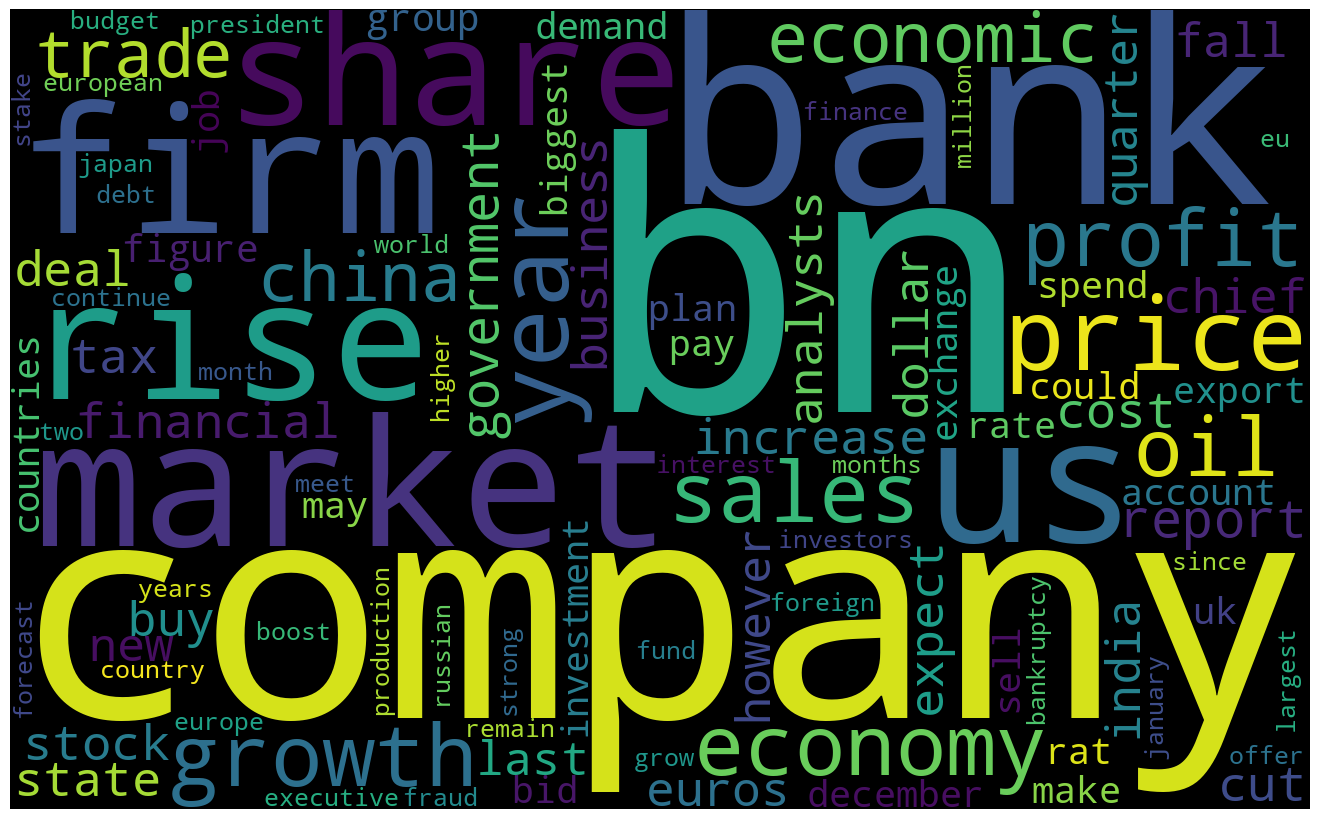

In [87]:
plot_wordcloud(top_words_tfidf[0])

*   Looking at the word distributions, it can be concluded that this is the **Politics** Topic

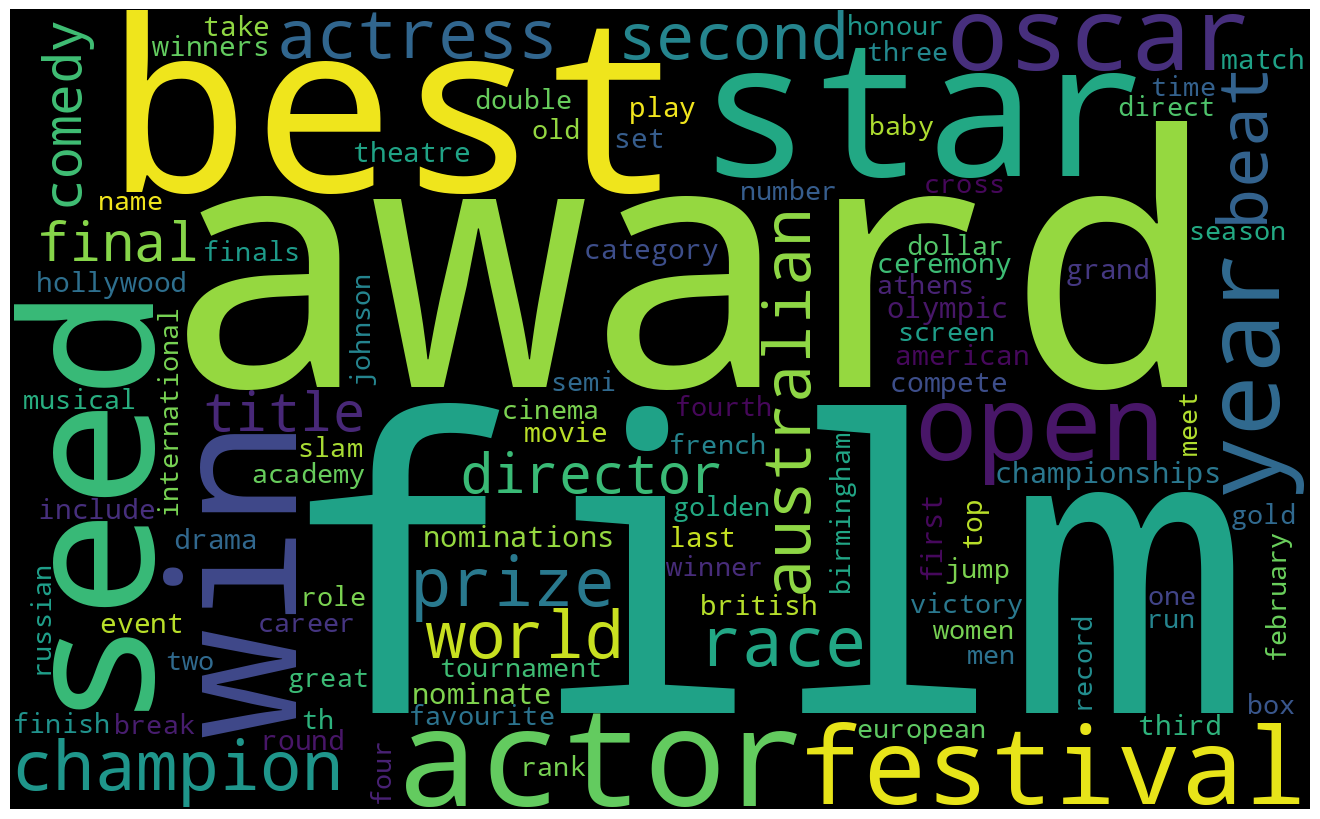

In [88]:
plot_wordcloud(top_words_tfidf[1])

*   Looking at the word distributions, it can be concluded that this is the **Sport** Topic

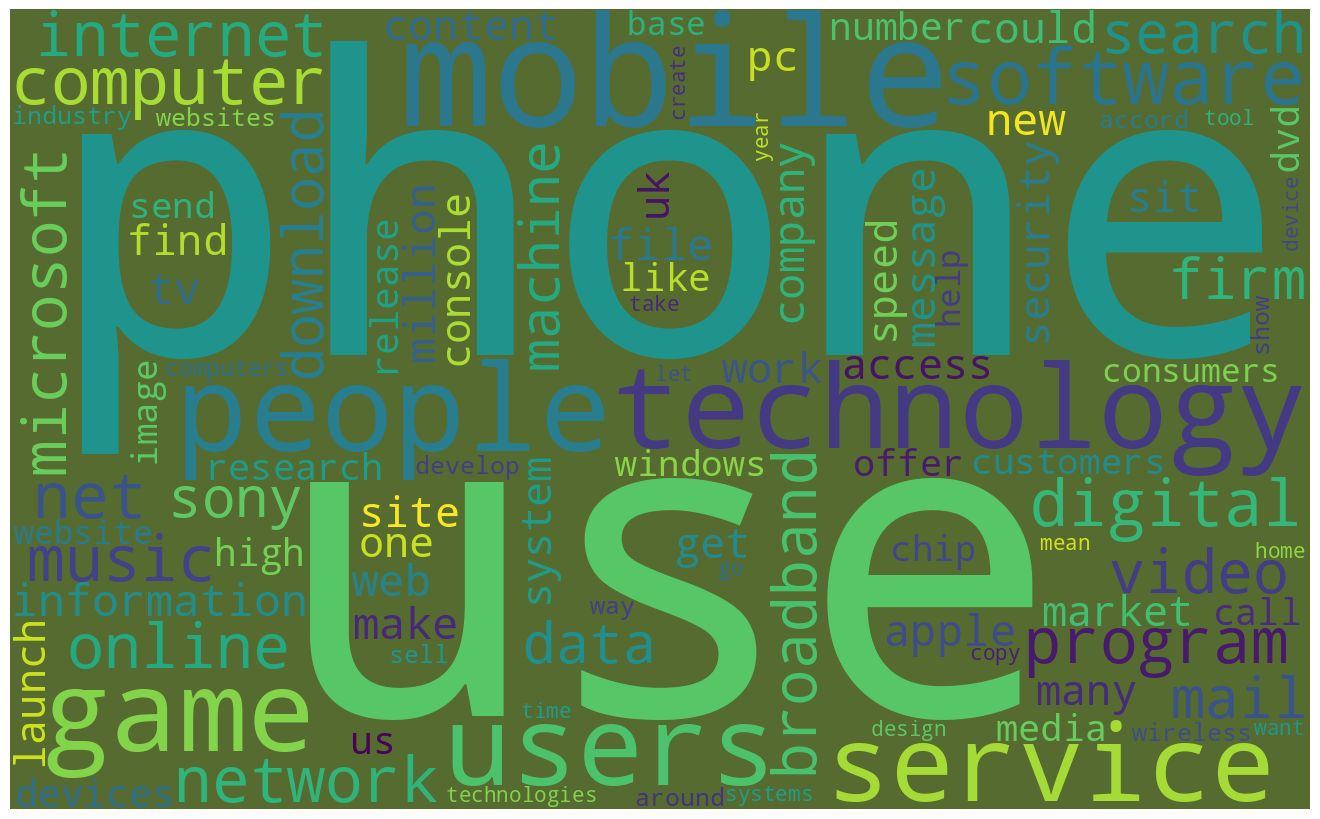

In [89]:
plot_wordcloud(top_words_tfidf[2])

*   Looking at the word distributions, it can be concluded that this is the **Tech** Topic

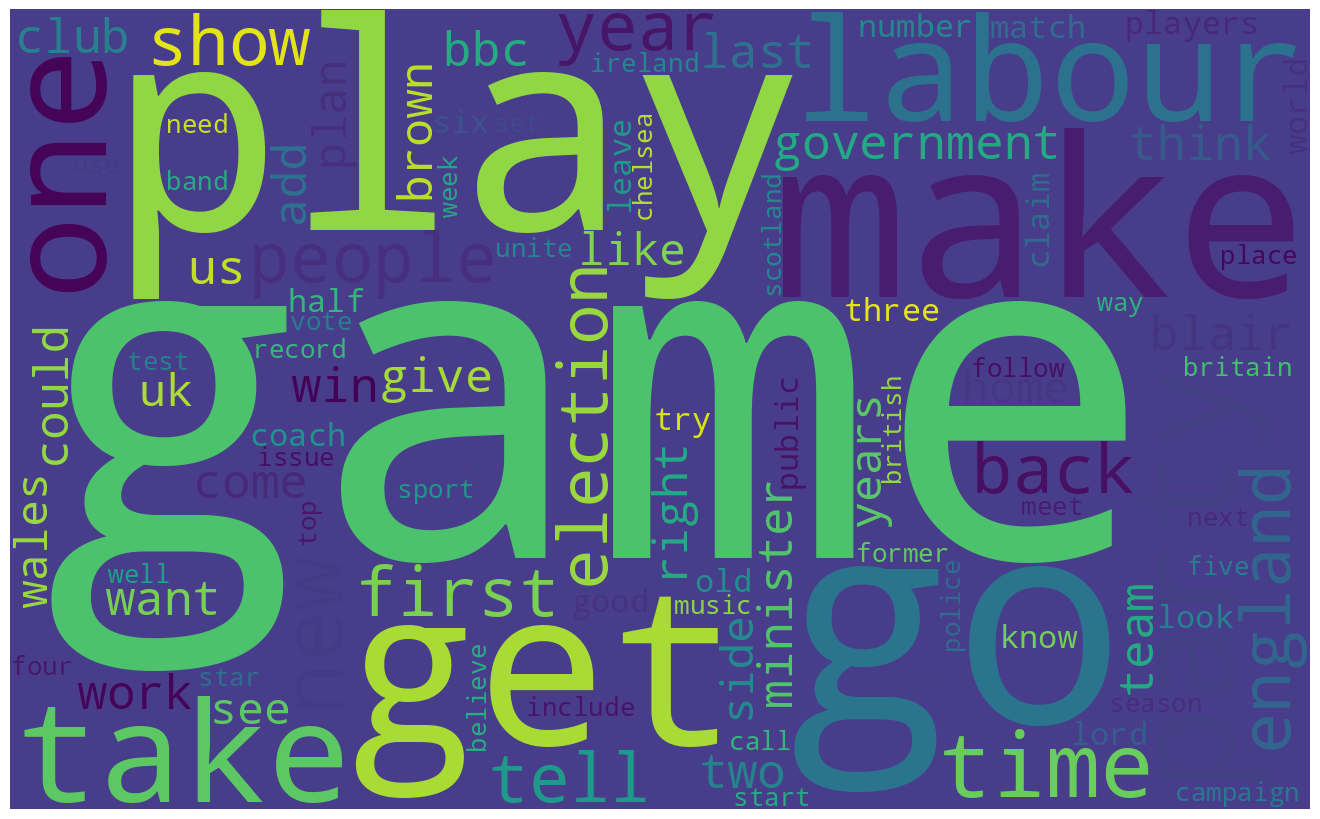

In [90]:
plot_wordcloud(top_words_tfidf[3])

*   Looking at the word distributions, it can be concluded that this is the **Entertainment** Topic

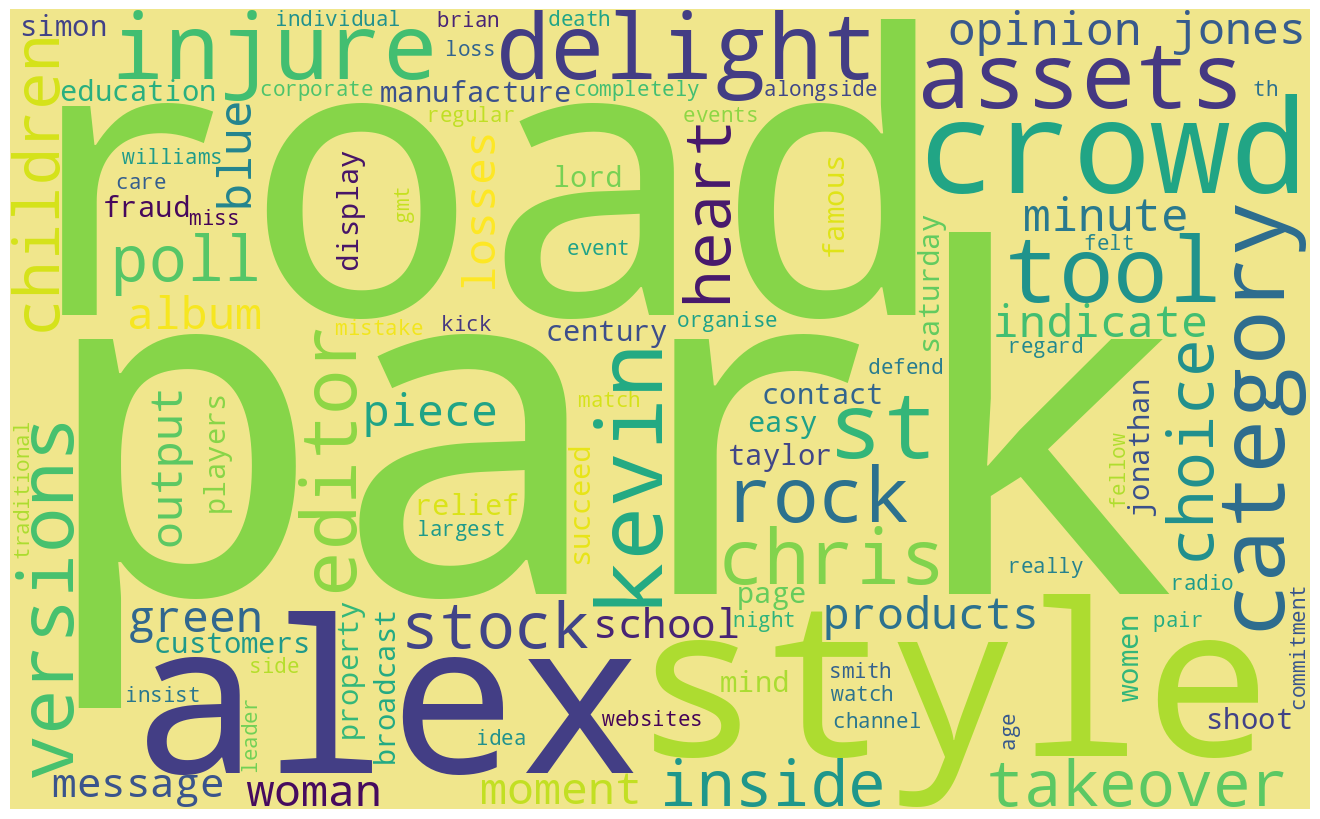

In [91]:
plot_wordcloud(top_words_tfidf[4])

*   Looking at the word distributions, it can be concluded that this is the **Business** Topic

### ML Model - 3 - **Latent Semantic Analysis**

For Latent Semantic Analysis, the TruncatedSVD algorithm is used. Two models are tried - one with TFIDF Vectorized data as input, and the other with CountVectorized data as input

In [92]:
# Fitting the LSA model on the TFIDF_Vectorized data
lsa_model = TruncatedSVD(n_components=5)
lsa_model.fit(tfidf_vectorized)

# Assigning the Topics categorised by LSA model to each document
result_df_lsa = assign_topics(data, tfidf_vectorized, lsa_model).rename(columns = {'Topic_LDA':'Topic_LSA'})
result_df_lsa.groupby('Topic_LSA')['Title'].count()

Topic_LSA
1    1820
2      53
3      95
4      57
5     100
Name: Title, dtype: int64

In [93]:
# Fitting the LSA model on the CountVectorized data
lsa_model = TruncatedSVD(n_components=5)
lsa_model.fit(tokenised_data)

# Assigning the Topics categorised by LSA model to each document
result_df_lsa = assign_topics(data, tfidf_vectorized, lsa_model).rename(columns = {'Topic_LDA':'Topic_LSA'})
result_df_lsa.groupby('Topic_LSA')['Title'].count()

Topic_LSA
1    1743
2      52
3      79
4      79
5     172
Name: Title, dtype: int64

*   It can be observed that the LSA algorithm when used on the dataset (tokenised with both TFIDF and the Bag-of-Words), over-determined one particular topic instead of the others

### 1. Which Evaluation metrics did you consider for a positive business impact and why?

*   **Perplixity and Log-likelihood score**:
  *   Perplexity, in the context of LDA, is a measure of how well the model is able to predict unseen documents. A lower perplexity score indicates that the model is better at predicting unseen documents.
  *   Log-likelihood is a measure of the capability of the model to explain the data. In general, a higher Log-likelihood and lower Perplexity is indicative of a good Topic Modeling Algorithm

*   However, these alone are not perfect metrics for evaluation of a Topic Modeling Algorithm. Since we are provided the original categories as an input, the metrics generally used for a Classification model could be used for evaluation along with the above two

*   **Accuracy** is the first of these metrics used for evaluation. Accuracy can be defined as the total number of articles correctly categorised by the model in proportion to the total articles categorised. **Precision** is a good metric to use if the priority is to avoid mis-categorisation of articles into a particular category when they originally don't. It measures the accuracy of identifying if the articles truly belong to a particular category. **Recall** is a good metric to use if the priority to avoid missing any articles which originally belong to a particular category
*   Since the client has not provided any hierarchy within the categories themselves, all the categories are considered equal in importance, and hence the **F1 Score** is primarily focused on, to balance the trade-off between Precision and Recall
  *    For example, in Model 1 for the **Politics** topic, **Recall** was as high as 99% indicating how good the model is in categorising articles originally belonging to Politics. But the fact that the model has also categorised articles originally in other categories as Politics is captured by **Precision**, which is only ~82%. Hence, the **F1 Score** is used to take into account both these metrics, **especially since no prior hierarchy between topics is a given**

*   In summary, **Perplexity**, **Log-likelihood**, **Accuracy** and **F1 Score** are primarily focused on to assess the power of the Topic Modeling Algorithm








### 2. Which ML model did you choose from the above created models as your final prediction model and why?

*   Based on an analysis of the above models, the first model - **LDA with CountVectorizer** - is chosen as the final prediction model.
*   On a simple view of the 3rd model using the Latent Semantic Analysis, it can be observed that the model - for both TFIDF and Count Vectorizers to tokenise the input dataset - over-predicts for one particular topic over the other four. This is highly inaccurate, and hence this model is dropped
*   On comparison between the other two models, the following are the evaluation metrics of the two:

In [94]:
print('Model 1: LDA with Count Vectorizer')
print(f"Log likelihood Score for the LDA model: {log_likelihood_m1}")
print(f"Perplixity of the LDA model: {perplexity_m1}")
print(f"Accuracy of the LDA model {round(model_accuracy(result_df),2)}%")
print(f"\n{prf1_m1}")

print("\n\nModel 2: LDA with TFIDF Vectorizer")
print(f"Log-likelihood Score for the LDA model: {log_likelihood_m2}")
print(f"Perplexity of the LDA model: {perplexity_m2}")
print(f"Accuracy of the LDA model {round(model_accuracy(result_df_tfidf),2)}%")
print(f"\n{prf1_m2}")

Model 1: LDA with Count Vectorizer
Log likelihood Score for the LDA model: -440013.84350437595
Perplixity of the LDA model: 742.406788750559
Accuracy of the LDA model 92.89%

           Topic     Recall  Precision   F1_Score
0       Business  85.089463  97.716895  90.967056
1  Entertainment  92.140921  96.317280  94.182825
2       Politics  98.511166  82.024793  89.515220
3          Sport  98.409543  97.058824  97.729516
4           Tech  90.489914  92.352941  91.411936


Model 2: LDA with TFIDF Vectorizer
Log-likelihood Score for the LDA model: -30188.01678182443
Perplexity of the LDA model: 2195.839426500326
Accuracy of the LDA model 55.39%

      Topic     Recall  Precision   F1_Score
0  Business  91.053678  95.815900  93.374108
1     Sport        NaN  35.644372        NaN
2      Tech        NaN  97.577855        NaN


It can be observed that:
*   Model 1 has a lower score of **Perplexity** than Model 2. Hence, it is deemed to be better at categorising unseen textual data.
*   Model 2 has a higher **Log-likelihood** score than Model 1. While Model 2 scores better in this metric, the other metrics below are worth observing
*   Model 1 has a much higher model **Accuracy** than Model 2 (higher by about ~10%)
*   Model 1 has in general, much better **Precision** and **Recall** for each topic than Model 2. While Model 2 scores a very high Precision in **Entertainment** Topic, it has very low recall. The **F1 Score** is much greater for Model 1 in almost every topic - except in **Business** and **Politics** category where it is almost the same

Based on the above results, Model 1 - LDA with CountVectorizer - is the obvious choice for Topic Modeling of this data.

Thus, **there is no sufficient proof to reject the Null Hypotheses** that CountVectorizer is a better choice than TFIDFVectorizer for tokenising data to be input into an LDA model.

# **Conclusion**

Some of the sectional conclusions from the project are:
*   Encoding errors like UnicodeError and Parsererror were encountered when reading some of the News article txt files. Exception handling was implemented for these articles to be read properly
*   In textual pre-processing, many further stopwords could be removed for further optimising the model. Words like "use", "go" etc. Words like "us" needs to be handled carefully as it can also mean the "United States"
*   The process of stemming was not implemented for pre-processing. Stemming simply chops off the end of a word to reduce it to its root form, whereas lemmatization considers the context and morphology of the word to reduce it to its base form. This is particularly important in topic modeling, where the goal is to identify the hidden topics in a corpus of texts. Since topics can often be conveyed through the nuances of language and the context in which words are used, it is important to use a method that preserves as much of the original meaning as possible
*   A Null hypotheses was established, for the choice between a CountVectorizer and TFIDFVectorizer for data tokenisation. It was found that the CountVectorizer is suitable for tokenising input textual data for LDA models. This is because LDA is a probabilistic model that models the word count distribution in a document and the topic distribution across documents. CountVectorizer converts text into an array of word counts, which is an ideal input for an LDA model
*   After implementing the LDA and LSA models, it was found that the LDA model (with Count Vectorizer used for tokenisation) indeed fared much better than the LSA model in categorising the underlying topics in the corpus of articles. The model accuracy was as high as 93%. On looking at the word distributions for each topic, a correlation between the most frequent words and the topics could be easily identified.

# **Future Scope**

Some areas where future work could be extended on this project are:
*   **Refining the stopwords removal further**, as has been discussed above in the **Conclusions** section
*   **Tuning of further Hyperparameters**. In the project, the optimum value of the number of topics as a hyperparameter was tuned. Further hyperparameters like *solver*, *store_covariance*, *tol* etc could be optimised sed to develop the model further. Random Search of Bayesian Search could be implemented to tackle the computational cost.
*   Many other models like the Non Negative Matrix Factorization (NMF), Parallel Latent Dirichlet Allocation (PLDA) and Pachinko Allocation Model (PAM) exist for Topic Modeling. Various such models could be implemented and their performance compared to select the best model in this context.
*   **Topic evolution with time**: BBC articles are produced every year and in abundance. Future work can also include analysing how the identified topics have evolved over time and exploring any patterns or trends.

*As a final note, thank you for joining me on this journey of exploring BBC News articles through topic modeling. It was a pleasure to share this experience with you!*